# Requirements and installs

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
import typing as t
import numpy as np
import pandas as pd
from dataclasses import dataclass
from zoneinfo import ZoneInfo
import unicodedata, re
import matplotlib.pyplot as plt
import seaborn as sns

# Utils básicos
def _pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        import subprocess, sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["holidays"]:
    _pip_install(pkg)

import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss
from sklearn.calibration import IsotonicRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import Bunch
from sklearn.utils.class_weight import compute_sample_weight
from fairlearn.metrics import MetricFrame
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler


from scipy.stats import ks_2samp
from scipy import stats

import optuna
from optuna.pruners import MedianPruner

import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


RNG_SEED = 42
np.random.seed(RNG_SEED)

# Config

In [3]:
@dataclass
class Config:
    project_id: str = "spin-aip-singularity-comp-sb"
    table_fqn: str = "spin-aip-singularity-comp-sb.model_activation.dataste_model_activation_timewindow_30D_V-1-5-0"
    label_col: str = "label_activated_30d"
    signup_ts_col: str = "signup_ts"
    signup_date_col: str = "signup_date"
    tz_local: str = "America/Mexico_City"
    embargo_days: int = 3      
    holdout_days: int = 14 
    n_splits: int = 5
    train_sample_frac: float = 1.0
    random_state: int = RNG_SEED
    lift_fracs: t.Tuple[float, ...] = (0.01, 0.02, 0.05, 0.10)

CFG = Config()

# Leakage / IDs a ignorar en features
LEAKY_ALWAYS = {
    # labels y derivados
    "y_w0","y_w1","y_w7","y_w30","y_cum30","label_activated_30d","label_5tx_30d",
    # info post-activación / post-window
    "activation_date_ever","activation_date_30d","days_to_first_activation",
    "tx_30d_count","tx_30d_amount","tx_30d_from_activation", "first_tx_type","first_tx_amount","latest_tx_date",
    # confirmaciones si no son estrictamente previas al cutoff de cada horizonte
#    "phn_confir","email_confir",
    "phn_confir_d7","email_confir_d7","both_confir_d7",'Card_linked_date',"activation_*","*_30d_*","*latest_tx*",
    #ID
    "user_id", "userid","channelUserIdentifier", "premia_accountid", "accountid", "member_id", "spin_user_id", "id"
}

LEAK_BAN = {
    "y_w0","y_w1","y_w7","y_w30","y_cum30","label_activated_30d","label_5tx_30d",
    "activation_date_ever","activation_date_30d","days_to_first_activation",
    "latest_tx_date","tx_30d_count","tx_30d_amount","tx_30d_from_activation",
    "first_tx_type","first_tx_amount","activation_channel"
}

# Regex anti-leak (además del set LEAKY_ALWAYS existente)
LEAK_PATTERNS = [
    r"(^|_)activation(_|$)", r"(^|_)first_tx(_|$)", r"(^|_)latest_tx(_|$)",
    r"(^|_)tx_30d(_|$)", r"(^|_)days_to_first(_|$)", r"(^|_)from_activation(_|$)"
]
def assert_no_regex_leak(df_like: pd.DataFrame):
    bad = []
    for c in df_like.columns:
        for pat in LEAK_PATTERNS:
            if re.search(pat, c, flags=re.IGNORECASE):
                bad.append(c); break
    assert len(bad) == 0, f"LEAKAGE by regex: quita columnas {sorted(set(bad))}"
def assert_no_labelish_cols(df_like):
    inter = [c for c in df_like.columns if c in LEAK_BAN]
    assert len(inter) == 0, f"LEAKAGE: quita columnas {inter}"


EXTRA_DROP_TS = {"phone_conf_ts", "email_conf_ts"}

# Normalización de estados (stateName -> siglas)
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^A-Z ]", "", s.upper())
    return re.sub(r"\s+", " ", s).strip()

STATE_TO_ABBR = {
    "AGUASCALIENTES":"AG","BAJA CALIFORNIA":"BC","BAJA CALIFORNIA SUR":"BS","CAMPECHE":"CM",
    "CHIAPAS":"CS","CHIHUAHUA":"CH","CIUDAD DE MEXICO":"DF","COAHUILA":"CO","COLIMA":"CL",
    "DURANGO":"DG","GUANAJUATO":"GT","GUERRERO":"GR","HIDALGO":"HG","JALISCO":"JA","MEXICO":"EM",
    "MICHOACAN":"MI","MORELOS":"MO","NAYARIT":"NA","NUEVO LEON":"NL","OAXACA":"OA","PUEBLA":"PU",
    "QUERETARO":"QT","QUINTANA ROO":"QR","SAN LUIS POTOSI":"SL","SINALOA":"SI","SONORA":"SO",
    "TABASCO":"TB","TAMAULIPAS":"TM","TLAXCALA":"TL","VERACRUZ":"VE","YUCATAN":"YU","ZACATECAS":"ZA"
}
STATE_SYNONYMS = {"CDMX":"CIUDAD DE MEXICO","ESTADO DE MEXICO":"MEXICO","EDOMEX":"MEXICO"}

# birthState canon + buckets regionales
CANON = {
    "SR":"SO","SO":"SO","VZ":"VE","VE":"VE","YN":"YU","YU":"YU","JC":"JA","JA":"JA","MC":"MI","MI":"MI",
    "TS":"TM","TM":"TM","TC":"TB","TB":"TB","CC":"CL","CL":"CL","DF":"DF","EM":"EM","NL":"NL","BC":"BC",
    "BS":"BS","SI":"SI","NA":"NA","DG":"DG","ZA":"ZA","AG":"AG","SL":"SL","HG":"HG","MO":"MO","TL":"TL",
    "PU":"PU","QT":"QT","GT":"GT","OA":"OA","CM":"CM","CS":"CS","CO":"CO","GR":"GR","QR":"QR","CH":"CH",
    "MS":"MI","MN":"MI","SP":"SL","NE":"NL","OC":"OA","PL":"PU","NT":"NA","ZS":"ZA","AS":"AG","UN":"OT", None:"OT"
}
REGION_BUCKET = {
    "BC":1,"SO":1,"CH":1,"CO":1,"NL":1,"TM":1,                # Norte
    "BS":2,"SI":2,"NA":2,"DG":2,"ZA":2,                       # Norte-Occidente
    "JA":3,"AG":3,"CL":3,"MI":3,"SL":3,                       # Centro-Norte
    "DF":4,"EM":4,"HG":4,"MO":4,"TL":4,"PU":4,"QT":4,"GT":4,  # Centro-País
    "CS":5,"TB":5,"CM":5,"YU":5,"QR":5,"OA":5,"GR":5,"VE":5,  # Sur-Sureste
    "OT":0
}

# Mapeos categóricos
GENDER_MAP = {"female":1, "male":0}
USER_TYPE_MAP = {"HYBRID":0, "DIGITAL":1, "ANALOG":2}
CHANNEL_DETAIL_MAP = {"ORGANIC":0,"COLLABORATOR":1,"POS":2,"SPIN_PREMIA":3,"DIGITAL_ORGANIC":4,"DIGITAL":5}

#CASH_IN_TX = {"CASH_IN_AT_OXXO","CASH_IN_AT_OXXO_QR"}

#SPEI_TX = {"SPEI_CASH_IN"}

#P2P_TX = {"P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CLABE","P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CARD"}

CASH_IN_TX = {
    "CASH_IN_AT_OXXO","CASH_IN_AT_OXXO_QR","CASH_OUT_WITH_CARD_AT_OXXO", "CASH_OUT_AT_OXXO","CASH_OUT_AT_MERCHANT","CARD_PURCHASE","CARD_ATM_WITHDRAWAL"
}
SPEI_TX = {"SPEI_CASH_IN","TRANSFER_TO_CARD","TRANSFER_TO_CLABE" "P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CLABE","P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CARD"}
   
P2P_TX ={"P2P_TRANSFER_TARGET_CLABE","P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CARD","P2P_TRANSFER_SOURCE_CARD","P2P_TRANSFER_SOURCE_CLABE",
    "P2P_TRANSFER_SOURCE","IN_APP_PURCHASE_TAE","IN_APP_PURCHASE_BILLPAYMENT","QR_MERCHANT_PAYMENT",
    "GIFT_CARD_PURCHASE","INTERNATIONAL_REMITTANCE_CASH_IN"}
    
TX_TYPE_MAP = {
    **{k: 0 for k in CASH_IN_TX},  # 0 = Cash_In
    **{k: 1 for k in SPEI_TX},     # 1 = SPEI
    **{k: 2 for k in P2P_TX}       # 2 = P2P
}
TX_TYPE_NAMES = {
    0: "Cash_In",
    1: "SPEI",
    2: "P2P"
}
TX_TRINARY_NAME = {0:"FISICAS", 1:"DIGITALES", 2:"P2P"}


# FeatureBuilder

In [4]:
class FeatureBuilder:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.ohe_states_: t.List[str] = []
        # NUEVO: Pipeline de normalización
        self.scaler_: RobustScaler | None = None
        self.numeric_cols_: t.List[str] = []
        self._fitted_scaler: bool = False

    @staticmethod
    def _state_to_abbr(s: t.Any) -> str:
        if pd.isna(s): return "OT"
        s = str(s)
        if s.upper() in REGION_BUCKET: return s.upper()
        s2 = _norm(s)
        s2 = STATE_SYNONYMS.get(s2, s2)
        return STATE_TO_ABBR.get(s2, "OT")

    @staticmethod
    def _canon_birthstate(s: t.Any) -> str:
        if pd.isna(s): return "OT"
        s = str(s).upper()
        return CANON.get(s, s if s in REGION_BUCKET else "OT")

    def _mk_time_feats(self, df: pd.DataFrame) -> pd.DataFrame:
        ts = pd.to_datetime(df[self.cfg.signup_ts_col], utc=True).dt.tz_convert(ZoneInfo(self.cfg.tz_local))
        df = df.copy()
        df["signup_dow"] = ts.dt.weekday.astype("int16")
        df["signup_week"] = ts.dt.isocalendar().week.astype("int16")
        df["signup_month"] = ts.dt.month.astype("int16")
        hr = ts.dt.hour
        df["signup_daypart"] = np.select([(hr>=5)&(hr<=11),(hr>=12)&(hr<=17)],[0,1],default=2).astype("int8")
        years = list({d.year for d in pd.to_datetime(df[self.cfg.signup_date_col]).dt.date})
        mx_hol = holidays.MX(years=years)
        dates = pd.to_datetime(df[self.cfg.signup_date_col]).dt.date
        df["is_holiday_mx"] = dates.map(lambda d: 1 if d in mx_hol else 0).astype("int8")
        day = ts.dt.day
        eom = (ts + pd.offsets.MonthEnd(0)).dt.day
        df["near_payday_any"] = ((np.abs(day-1)<=3)|(np.abs(day-15)<=3)|(np.abs(day-eom)<=3)).astype("int8")
        df["near_payday_1st"] = (np.abs(day-1)<=3).astype("int8")
        df["near_payday_15"]  = (np.abs(day-15)<=3).astype("int8")
        df["near_payday_eom"] = (np.abs(day-eom)<=3).astype("int8")
        return df

    def fit(self, df: pd.DataFrame):
        st = df["stateName"].map(self._state_to_abbr)
        self.ohe_states_ = sorted(st.dropna().unique().tolist())
        if "OT" not in self.ohe_states_: self.ohe_states_.append("OT")
        return self

    def transform(self, df: pd.DataFrame) -> Bunch:
        df = df.copy()
        s_ts = pd.to_datetime(df[CFG.signup_ts_col], utc=True)

        # Categóricas core
        df["gender_bin"] = df["gender"].map(GENDER_MAP).astype("float32")
        df["user_type_tri"] = df["user_type"].map(USER_TYPE_MAP).astype("float32")
        df["channel_detail_code"] = df["channelDetail"].map(CHANNEL_DETAIL_MAP).astype("float32")

        # birth bucket + edad
        bcanon = df["birthState"].map(self._canon_birthstate)
        df["birth_bucket"] = bcanon.map(REGION_BUCKET).astype("float32")
        bdate = pd.to_datetime(df["birth_date"], errors="coerce", utc=True)
        df["age_years"] = ((s_ts - bdate).dt.days/365.25).astype("float32")

        # Time features
        df = self._mk_time_feats(df)

        # state OHE
        st = df["stateName"].map(self._state_to_abbr)
        for ab in self.ohe_states_:
            df[f"state_{ab}"] = (st==ab).astype("int8")

        # Confirmaciones / flags: Int nulos a 0
        if "phone_conf_ts" in df.columns:
            phn_ts = pd.to_datetime(df["phone_conf_ts"], errors="coerce", utc=True)
            df["phn_confir"] = (phn_ts < s_ts).fillna(False).astype("int8")
        else:
            df["phn_confir"] = 0

        if "email_conf_ts" in df.columns:
            email_ts = pd.to_datetime(df["email_conf_ts"], errors="coerce", utc=True)
            df["email_confir"] = (email_ts < s_ts).fillna(False).astype("int8")
        else:
            df["email_confir"] = 0

        # Card_linked_date -> deltas sin fuga
        if "Card_linked_date" in df.columns:
            card_dt = pd.to_datetime(df["Card_linked_date"], errors="coerce", utc=True)
            # Cambiar <= por < (estrictamente antes)
            before = card_dt < s_ts  
            lag_days = (s_ts - card_dt).dt.days.astype("float32")
            df["card_linked_before_signup"] = before.fillna(False).astype("int8")
            # Solo crear lag_days si ocurrió ANTES (no <=)
            df["card_linked_lag_days"] = np.where(before, lag_days, np.nan).astype("float32")
            df = df.drop(columns=["Card_linked_date"])

        LEAKY_FEATURES = {
            'lifespan_days',        #  LEAKAGE CONFIRMADO (corr=0.535)
            'days_since_last',      #  Sospechoso (corr=0.329)
        }

            
        # Armar X
        drop_cols = set(LEAKY_ALWAYS) | {
            "stateName","gender","user_type","channelDetail","birthState","birth_date",
            CFG.signup_date_col, CFG.signup_ts_col
        } | set(EXTRA_DROP_TS) | LEAKY_FEATURES  # ← MODIFICAR ESTA LÍNEA

        drop_cols = [c for c in drop_cols if c in df.columns]
        X = df.drop(columns=drop_cols, errors="ignore")

        # Limpiar tipos
        # 1) Si queda algún dtype extension de BigQuery -> fuera
        bad_ext = [c for c in X.columns if "db_dtypes" in str(X[c].dtype).lower() or "dbdate" in str(X[c].dtype).lower()]
        X = X.drop(columns=bad_ext, errors="ignore")

        # 2) Casts seguros
        for c in X.columns:
            if pd.api.types.is_integer_dtype(X[c]) or str(X[c].dtype).startswith("Int"):
                X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0).astype("float32")
            elif pd.api.types.is_float_dtype(X[c]):
                X[c] = X[c].astype("float32")
            elif pd.api.types.is_bool_dtype(X[c]):
                X[c] = X[c].astype("int8")
            elif pd.api.types.is_datetime64_any_dtype(X[c]):
                X = X.drop(columns=[c])

        # 3) Objetos -> fuera
        obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
        if obj_cols:
            X = X.drop(columns=obj_cols)

        # NUEVO: Normalización con RobustScaler
        if not self._fitted_scaler:
            # Primera vez: identificar columnas numéricas y fit scaler
            numeric_cols = [c for c in X.columns
                            if not c.startswith('state_')  # Excluir one-hot de estados
                            and X[c].dtype == 'float32'     # Solo float32
                            and X[c].nunique() > 10]        # Excluir binarias
            
            self.numeric_cols_ = numeric_cols
            
            if len(numeric_cols) > 0:
                self.scaler_ = RobustScaler()
                self.scaler_.fit(X[numeric_cols])
                self._fitted_scaler = True
                print(f'✓ RobustScaler fitted con {len(numeric_cols)} features numéricas')
            else:
                print('⚠️  No se encontraron features numéricas para normalizar')
                self._fitted_scaler = True
        
        # Aplicar normalización si existe
        if self.scaler_ is not None and len(self.numeric_cols_) > 0:
            existing_cols = [c for c in self.numeric_cols_ if c in X.columns]
            if len(existing_cols) > 0:
                X[existing_cols] = self.scaler_.transform(X[existing_cols])

        # y binaria
        y = pd.to_numeric(df[CFG.label_col], errors="coerce").fillna(0).astype(int).values
        
        assert_no_regex_leak(X)
        LEAK_BAN = LEAKY_ALWAYS | {"first_tx_type", "first_tx_amount"}
        assert_no_labelish_cols(X)
        
        meta = pd.DataFrame({
            "user_id": df.get("user_id", pd.Series(index=df.index, dtype="object")),
            "signup_date": pd.to_datetime(df[CFG.signup_date_col], errors="coerce"),
            "gender": df["gender"].astype(str),
            "channelDetail": df["channelDetail"].astype(str),
            "state_abbr": st.astype(str)
        })
        return Bunch(X=X, y=y, meta=meta)

# Modelo W30

In [5]:
def lift_at_k(y_true, y_score, frac: float) -> float:
    n = len(y_true); k = max(1, int(n*frac))
    idx = np.argpartition(-y_score, k-1)[:k]
    top_pos = y_true[idx].sum()
    base_rate = y_true.mean()
    expected_pos = k*base_rate
    return float(top_pos/expected_pos) if expected_pos>0 else np.nan

class Activation30Model:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model_folds_: t.List[HistGradientBoostingClassifier] = []
        self.iso_folds_: t.List[IsotonicRegression] = []
        self.metrics_ = {}
        self.oof_pred_ = None
        self.feature_names_: t.List[str] = []

    def _make_model(self):
        return HistGradientBoostingClassifier(
            learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=50,
            l2_regularization=1.0, max_bins=255, random_state=self.cfg.random_state
        )
    def _apply_embargo(self, train_idx: np.ndarray, val_idx: np.ndarray, 
                       time_order: np.ndarray) -> t.Tuple[np.ndarray, np.ndarray]:
        """Purga registros del train/val que violen el embargo temporal"""
        if self.cfg.embargo_days == 0:
            return train_idx, val_idx

        # Convertir a pandas Timestamp para operaciones seguras
        train_dates = pd.to_datetime(time_order[train_idx])
        val_dates = pd.to_datetime(time_order[val_idx])

        # Última fecha de train
        last_train_date = train_dates.max()

        # Calcular embargo cutoff
        embargo_cutoff = last_train_date + pd.Timedelta(days=self.cfg.embargo_days)

        # Filtrar validación
        val_valid_mask = val_dates >= embargo_cutoff
        val_filtered = val_idx[val_valid_mask]

        # VALIDACIÓN CRÍTICA: Asegurar mínimo de muestras
        min_samples = 100  # mínimo razonable para HistGradientBoosting
        if len(val_filtered) < min_samples:
            print(f" WARNING: Embargo dejó {len(val_filtered)} muestras (< {min_samples}). "
                  f"Usando fold completo sin embargo.")
            return train_idx, val_idx

        removed = len(val_idx) - len(val_filtered)
        print(f"✓ Embargo aplicado: {removed} muestras removidas de validación "
              f"({removed/len(val_idx)*100:.1f}%)")

        return train_idx, val_filtered

    def fit_cv(self, X: pd.DataFrame, y: np.ndarray, time_order: np.ndarray):
        # ordenar temporal
        order = np.argsort(time_order)
        X = X.iloc[order].reset_index(drop=True)
        y = y[order]
        time_order_sorted = pd.to_datetime(time_order[order])

        tss = TimeSeriesSplit(n_splits=self.cfg.n_splits)
        oof = np.zeros(len(X), dtype=float)
        self.model_folds_.clear()
        self.iso_folds_.clear()
        self.feature_names_ = X.columns.tolist()

        for f, (tr, va) in enumerate(tss.split(X)):
            # embargo con fechas ya ordenadas
            tr, va = self._apply_embargo(tr, va, time_order_sorted)

            Xtr, Xva = X.iloc[tr], X.iloc[va]
            ytr, yva = y[tr], y[va]

            sw = compute_sample_weight(class_weight="balanced", y=ytr).astype("float32")

            m = self._make_model()
            m.fit(Xtr, ytr, sample_weight=sw)

            p_raw = m.predict_proba(Xva)[:, 1]
            iso = IsotonicRegression(out_of_bounds="clip").fit(p_raw, yva)
            p_cal = iso.transform(p_raw)
            oof[va] = p_cal

            self.model_folds_.append(m)
            self.iso_folds_.append(iso)
            print(f"[Fold {f+1}] AP={average_precision_score(yva,p_cal):.4f} | "
                  f"AUC={roc_auc_score(yva,p_cal):.4f} | "
                  f"Brier={brier_score_loss(yva,p_cal):.4f}")

        self.oof_pred_ = oof
        self.metrics_ = {
            "OOF_AP": average_precision_score(y, oof),
            "OOF_AUC": roc_auc_score(y, oof),
            "OOF_Brier": brier_score_loss(y, oof),
            **{f"OOF_Lift@{int(fr*100)}%": lift_at_k(y, oof, fr) for fr in self.cfg.lift_fracs}
        }
        return self


    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        preds = np.zeros(len(X), dtype=float)
        for m, iso in zip(self.model_folds_, self.iso_folds_):
            preds += iso.transform(m.predict_proba(X)[:,1])
        return preds / max(1, len(self.model_folds_))

# Model type of transaction

In [6]:
class TxTypeModel:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model_: HistGradientBoostingClassifier | None = None
        self.classes_: np.ndarray | None = None

    def _make_model(self):
        return HistGradientBoostingClassifier(
            learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=50,
            l2_regularization=1.0, max_bins=255, random_state=self.cfg.random_state
        )

    def fit(self, X: pd.DataFrame, y_tx: np.ndarray):
        # Pesos por clase inversos a la frecuencia
        classes, counts = np.unique(y_tx, return_counts=True)
        inv_freq = {c: (counts.sum()/ (len(classes)*cnt)) for c, cnt in zip(classes, counts)}
        sw = np.array([inv_freq[v] for v in y_tx], dtype="float32")

        m = self._make_model()
        m.fit(X, y_tx, sample_weight=sw)
        self.model_ = m
        self.classes_ = classes
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        assert self.model_ is not None
        proba = self.model_.predict_proba(X)
        # asegurar columnas en orden [0,1,2]
        out = np.zeros((len(X), 3), dtype=float)
        for i, c in enumerate(self.classes_):
            out[:, int(c)] = proba[:, i]
        return out

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return np.argmax(self.predict_proba(X), axis=1)

# Data Load, build Features, training

In [7]:
# DATA LOAD, FEATURE ENGINEERING & TRAINING

# 4.1 Carga
try:
    from google.cloud import bigquery
    client = bigquery.Client(project=CFG.project_id)
    data_raw = client.query(f"SELECT * FROM `{CFG.table_fqn}`").to_dataframe()
    print(f"✓ Data cargada desde BigQuery: {data_raw.shape}")
except Exception as e:
    print(f"BigQuery no disponible: {e}")
    print("Asumiendo que 'data_raw' ya existe en el entorno.")
    # data_raw = data  # fallback si ya existe

data_raw = data_raw[~data_raw[CFG.label_col].isna()].copy()
  
# 4.2 Separar holdout ANTES de feature engineering
# Calcular cutoffs
max_signup = pd.to_datetime(data_raw[CFG.signup_date_col]).max()
test_cutoff = max_signup - pd.Timedelta(days=int(CFG.holdout_days * 0.6))  # 15% = 8-9 días
val_cutoff = test_cutoff - pd.Timedelta(days=int(CFG.holdout_days * 1.0))  # 25% = 14 días

signup_dates = pd.to_datetime(data_raw[CFG.signup_date_col])
max_signup = pd.to_datetime(data_raw[CFG.signup_date_col]).max()
holdout_cutoff = max_signup - pd.Timedelta(days=CFG.holdout_days)
# Crear máscaras
mask_train = signup_dates < val_cutoff
mask_val = (signup_dates >= val_cutoff) & (signup_dates < test_cutoff)
mask_test = signup_dates >= test_cutoff

mask_train = pd.to_datetime(data_raw[CFG.signup_date_col]) < holdout_cutoff
data_train = data_raw[mask_train].copy()
data_holdout = data_raw[~mask_train].copy()

# Split datasets
data_train = data_raw[mask_train].copy()
data_val = data_raw[mask_val].copy()
data_test = data_raw[mask_test].copy()

# 4.3 Feature engineering EN TRAIN
fb = FeatureBuilder(CFG).fit(data_train)
fe_train = fb.transform(data_train)
X_train, y_train, meta_train = fe_train.X, fe_train.y, fe_train.meta
print(f"✓ Features engineered: {X_train.shape[1]} features")

# 4.4 Modelo W30 (binario) - SOLO EN TRAIN
print("\nEntrenando modelo W30 (activación binaria)...")
time_order = pd.to_datetime(data_train[CFG.signup_date_col], errors="coerce").values
m_w30 = Activation30Model(CFG).fit_cv(X_train, y_train, time_order)

print("\n=== MÉTRICAS OOF (Train) ===")
for k, v in m_w30.metrics_.items():
    print(f"  {k}: {v:.4f}")

# 4.5 Evaluar en HOLDOUT (simula producción)
fe_holdout = fb.transform(data_holdout)
X_holdout, y_holdout, meta_holdout = fe_holdout.X, fe_holdout.y, fe_holdout.meta
score_holdout = m_w30.predict_proba(X_holdout)

holdout_metrics = {
    "Holdout_AP": average_precision_score(y_holdout, score_holdout),
    "Holdout_AUC": roc_auc_score(y_holdout, score_holdout),
    "Holdout_Brier": brier_score_loss(y_holdout, score_holdout),
    **{f"Holdout_Lift@{int(fr * 100)}%": lift_at_k(y_holdout, score_holdout, fr)
       for fr in CFG.lift_fracs}
}
print("\n=== MÉTRICAS HOLDOUT (Simulación Producción) ===")
for k, v in holdout_metrics.items():
    print(f"  {k}: {v:.4f}")

# ============================================
# 4.6 MODELO TIPO DE TRANSACCIÓN (MULTICLASE)
# ============================================
print("\nEntrenando modelo tipo de transacción (Cash_In / SPEI / P2P)...")

# Crear labels multiclase para usuarios activados en TRAIN
ft = data_train["first_tx_type"].astype(object)
y_tx_raw = ft.where(data_train[CFG.label_col] == 1, np.nan)

# CAMBIO CLAVE: Usar TX_TYPE_MAP (nueva categorización)
y_tx_coded = y_tx_raw.map(TX_TYPE_MAP)
mask_train_tx = y_tx_coded.notna()

X_tx_train = X_train.loc[mask_train_tx].reset_index(drop=True)
y_tx_train = y_tx_coded.loc[mask_train_tx].astype(int).values

print(f"✓ Entrenando con {len(X_tx_train)} usuarios activados")
print(f"  Distribución de clases:")
for label, name in TX_TYPE_NAMES.items():
    count = (y_tx_train == label).sum()
    pct = count / len(y_tx_train) * 100
    print(f"    {name}: {count} ({pct:.1f}%)")

# 4.7 Train multiclase
m_tx = TxTypeModel(CFG).fit(X_tx_train, y_tx_train)
print("✓ Modelo tipo de transacción entrenado")

# ============================================
# 4.8 PREDICCIONES COMPLETAS (TRAIN + HOLDOUT)
# ============================================
X_all = pd.concat([X_train, X_holdout], axis=0, ignore_index=True)
meta_all = pd.concat([meta_train, meta_holdout], axis=0, ignore_index=True)
y_all = np.concatenate([y_train, y_holdout])

score_w30_all = m_w30.predict_proba(X_all)
proba_tx_all = m_tx.predict_proba(X_all)
tx_reco_all = np.argmax(proba_tx_all, axis=1)

# ============================================
# 4.9 DATAFRAME FINAL CON SCORES
# ============================================
# CAMBIO CLAVE: Nuevos nombres de columnas
preds_w30_tx = pd.DataFrame({
    "user_id": meta_all["user_id"].values,
    "signup_date": meta_all["signup_date"].values,
    "score_w30": score_w30_all,
    "tx_type_reco": tx_reco_all,
    "tx_type_reco_name": pd.Series(tx_reco_all).map(TX_TYPE_NAMES).values, 
    "score_cash_in": proba_tx_all[:, 0],    
    "score_spei": proba_tx_all[:, 1],       
    "score_p2p": proba_tx_all[:, 2],          
    "is_holdout": np.concatenate([
        np.zeros(len(X_train), dtype=bool),
        np.ones(len(X_holdout), dtype=bool)
    ])
})



# 5.1 Resumen OOF vs HOLDOUT (modelo W30)
rows = [
    {"metric": "AP",    "oof": m_w30.metrics_["OOF_AP"],   "holdout": holdout_metrics["Holdout_AP"]},
    {"metric": "AUC",   "oof": m_w30.metrics_["OOF_AUC"],  "holdout": holdout_metrics["Holdout_AUC"]},
    {"metric": "Brier", "oof": m_w30.metrics_["OOF_Brier"],"holdout": holdout_metrics["Holdout_Brier"]},
]

for fr in CFG.lift_fracs:
    k = int(fr*100)
    rows.append({
        "metric": f"Lift@{k}%",
        "oof": m_w30.metrics_.get(f"OOF_Lift@{k}%"),
        "holdout": holdout_metrics.get(f"Holdout_Lift@{k}%")
    })

df_val = pd.DataFrame(rows)
display(df_val)


# 5.2 Validación del modelo TxType en HOLDOUT (solo usuarios activados)

# Labels verdaderos en holdout
ft_holdout = data_holdout["first_tx_type"].astype(object)
y_tx_holdout_raw = ft_holdout.where(data_holdout[CFG.label_col] == 1, np.nan)
y_tx_holdout_coded = y_tx_holdout_raw.map(TX_TYPE_MAP)

mask_eval = y_tx_holdout_coded.notna()
X_tx_holdout = X_holdout.loc[mask_eval].reset_index(drop=True)
y_tx_holdout = y_tx_holdout_coded.loc[mask_eval].astype(int).values

proba_tx_holdout = m_tx.predict_proba(X_tx_holdout)
y_tx_holdout_pred = proba_tx_holdout.argmax(axis=1)

print(f"N usuarios activados en holdout con first_tx_type válido: {len(y_tx_holdout)}")

# Distribución real
print("\nDistribución real (holdout):")
print(pd.Series(y_tx_holdout).map(TX_TYPE_NAMES).value_counts(normalize=True))

# Matriz de confusión
labels_sorted = sorted(TX_TYPE_NAMES.keys())
cm = confusion_matrix(y_tx_holdout, y_tx_holdout_pred, labels=labels_sorted)
cm_df = pd.DataFrame(
    cm,
    index=[f"real_{TX_TYPE_NAMES[i]}" for i in labels_sorted],
    columns=[f"pred_{TX_TYPE_NAMES[i]}" for i in labels_sorted]
)
display(cm_df)

acc = (y_tx_holdout_pred == y_tx_holdout).mean()
print(f"\nAccuracy global (holdout): {acc:.3f}")


# Ordenar por propensity
preds_w30_tx = preds_w30_tx.sort_values("score_w30", ascending=False).reset_index(drop=True)

print("\n=== PREVIEW TOP 20 ===" )
display(preds_w30_tx.head(20))

print(f"✓ Train: {data_train.shape} ({mask_train.sum() / len(data_raw) * 100:.1f}%)")
print(f"✓ Validation: {data_val.shape} ({mask_val.sum() / len(data_raw) * 100:.1f}%)")
print(f"✓ Test: {data_test.shape} ({mask_test.sum() / len(data_raw) * 100:.1f}%)")
print(f"\n  Train period: {data_train[CFG.signup_date_col].min()} → {data_train[CFG.signup_date_col].max()}")
print(f"  Validation period: {data_val[CFG.signup_date_col].min()} → {data_val[CFG.signup_date_col].max()}")
print(f"  Test period: {data_test[CFG.signup_date_col].min()} → {data_test[CFG.signup_date_col].max()}")

# IMPORTANTE: Test set NO se usa hasta el final
print("\n⚠️  TEST SET RESERVADO - No usar hasta evaluación final")

print(f"\nPipeline completo ejecutado: {len(preds_w30_tx)} usuarios con scores")

✓ Data cargada desde BigQuery: (2384265, 37)
✓ RobustScaler fitted con 3 features numéricas
✓ Features engineered: 55 features

Entrenando modelo W30 (activación binaria)...
✓ Embargo aplicado: 22918 muestras removidas de validación (6.1%)
[Fold 1] AP=0.8061 | AUC=0.7637 | Brier=0.1853
✓ Embargo aplicado: 17970 muestras removidas de validación (4.8%)
[Fold 2] AP=0.8061 | AUC=0.7605 | Brier=0.1866
✓ Embargo aplicado: 24276 muestras removidas de validación (6.5%)
[Fold 3] AP=0.8053 | AUC=0.7649 | Brier=0.1860
✓ Embargo aplicado: 26538 muestras removidas de validación (7.1%)
[Fold 4] AP=0.8141 | AUC=0.7693 | Brier=0.1835
✓ Embargo aplicado: 22506 muestras removidas de validación (6.0%)
[Fold 5] AP=0.8213 | AUC=0.7763 | Brier=0.1797

=== MÉTRICAS OOF (Train) ===
  OOF_AP: 0.7698
  OOF_AUC: 0.6603
  OOF_Brier: 0.2800
  OOF_Lift@1%: 1.4975
  OOF_Lift@2%: 1.4827
  OOF_Lift@5%: 1.4435
  OOF_Lift@10%: 1.4058

=== MÉTRICAS HOLDOUT (Simulación Producción) ===
  Holdout_AP: 0.8287
  Holdout_AUC: 0

,metric,oof,holdout
0,AP,0.769778,0.828728
1,AUC,0.660261,0.775310
2,Brier,0.279975,0.178771
3,Lift@1%,1.497498,1.441662
4,Lift@2%,1.482712,1.428707
5,Lift@5%,1.443536,1.401556
6,Lift@10%,1.405799,1.386205


N usuarios activados en holdout con first_tx_type válido: 76896

Distribución real (holdout):
SPEI       0.453223
Cash_In    0.447865
P2P        0.098913
Name: proportion, dtype: float64


,pred_Cash_In,pred_SPEI,pred_P2P
real_Cash_In,10134,14551,9754
real_SPEI,4262,18103,12486
real_P2P,795,3213,3598



Accuracy global (holdout): 0.414

=== PREVIEW TOP 20 ===


,user_id,signup_date,score_w30,tx_type_reco,tx_type_reco_name,score_cash_in,score_spei,score_p2p,is_holdout
0,40fe6c4a-2e2e-4a2d-9c6c-4ea53e8bbe9a,2025-01-28,0.989416,1,SPEI,0.256464,0.392519,0.351017,False
1,f992521c-f10b-49fc-8af3-72d32aace5fd,2025-05-19,0.989416,1,SPEI,0.221047,0.405171,0.373781,False
2,7912219b-ecd6-4979-a342-ae802be5421a,2025-05-12,0.989416,1,SPEI,0.280214,0.418005,0.301780,False
3,83992dca-9c7a-4cc9-9424-f34f960f3970,2025-03-22,0.989416,1,SPEI,0.284245,0.416538,0.299217,False
4,e55805d3-c2bd-4a40-b2ec-781816948224,2025-06-22,0.989416,1,SPEI,0.178573,0.476687,0.344740,False
5,955e9bdc-a6d3-47ee-9f2e-a540025913b5,2025-06-09,0.989416,1,SPEI,0.280797,0.397680,0.321522,False
6,a1eca6c9-187e-4df9-8db4-71d099a34753,2025-07-19,0.989416,1,SPEI,0.224526,0.442516,0.332958,False
7,218f09b4-b53b-41f2-bc6e-61e35812cd21,2025-07-21,0.989416,1,SPEI,0.271816,0.377705,0.350478,False
8,c78c3ae8-a94c-41e5-ab30-2165abe051d1,2025-03-24,0.989416,1,SPEI,0.307483,0.370381,0.322136,False
9,27be755f-0476-47ca-bdc0-f4de548214d9,2025-06-16,0.989416,1,SPEI,0.206170,0.510783,0.283047,False


✓ Train: (2256514, 37) (94.6%)
✓ Validation: (127785, 37) (5.4%)
✓ Test: (75835, 37) (3.2%)

  Train period: 2025-01-01 → 2025-10-06
  Validation period: 2025-09-29 → 2025-10-12
  Test period: 2025-10-13 → 2025-10-21

⚠️  TEST SET RESERVADO - No usar hasta evaluación final

Pipeline completo ejecutado: 2384265 usuarios con scores


In [8]:
# =========================================================
# TEST & VALIDATION – RESUMEN W30 (OOF vs HOLDOUT)
# =========================================================

rows = []

# Métricas base
pairs = [
    ("AP",    "OOF_AP",      "Holdout_AP"),
    ("AUC",   "OOF_AUC",     "Holdout_AUC"),
    ("Brier", "OOF_Brier",   "Holdout_Brier"),
]

for name, key_oof, key_ho in pairs:
    rows.append({
        "metric": name,
        "oof": m_w30.metrics_.get(key_oof),
        "holdout": holdout_metrics.get(key_ho),
        "delta_holdout_minus_oof": holdout_metrics.get(key_ho) - m_w30.metrics_.get(key_oof)
    })

# Lifts
for fr in CFG.lift_fracs:
    k = int(fr*100)
    key_oof = f"OOF_Lift@{k}%"
    key_ho  = f"Holdout_Lift@{k}%"
    rows.append({
        "metric": f"Lift@{k}%",
        "oof": m_w30.metrics_.get(key_oof),
        "holdout": holdout_metrics.get(key_ho),
        "delta_holdout_minus_oof": holdout_metrics.get(key_ho) - m_w30.metrics_.get(key_oof)
    })

df_val_w30 = pd.DataFrame(rows)
display(df_val_w30)


,metric,oof,holdout,delta_holdout_minus_oof
0,AP,0.769778,0.828728,0.058950
1,AUC,0.660261,0.775310,0.115050
2,Brier,0.279975,0.178771,-0.101205
3,Lift@1%,1.497498,1.441662,-0.055836
4,Lift@2%,1.482712,1.428707,-0.054006
5,Lift@5%,1.443536,1.401556,-0.041980
6,Lift@10%,1.405799,1.386205,-0.019594



ANÁLISIS DE CALIBRACIÓN - TRAIN OOF


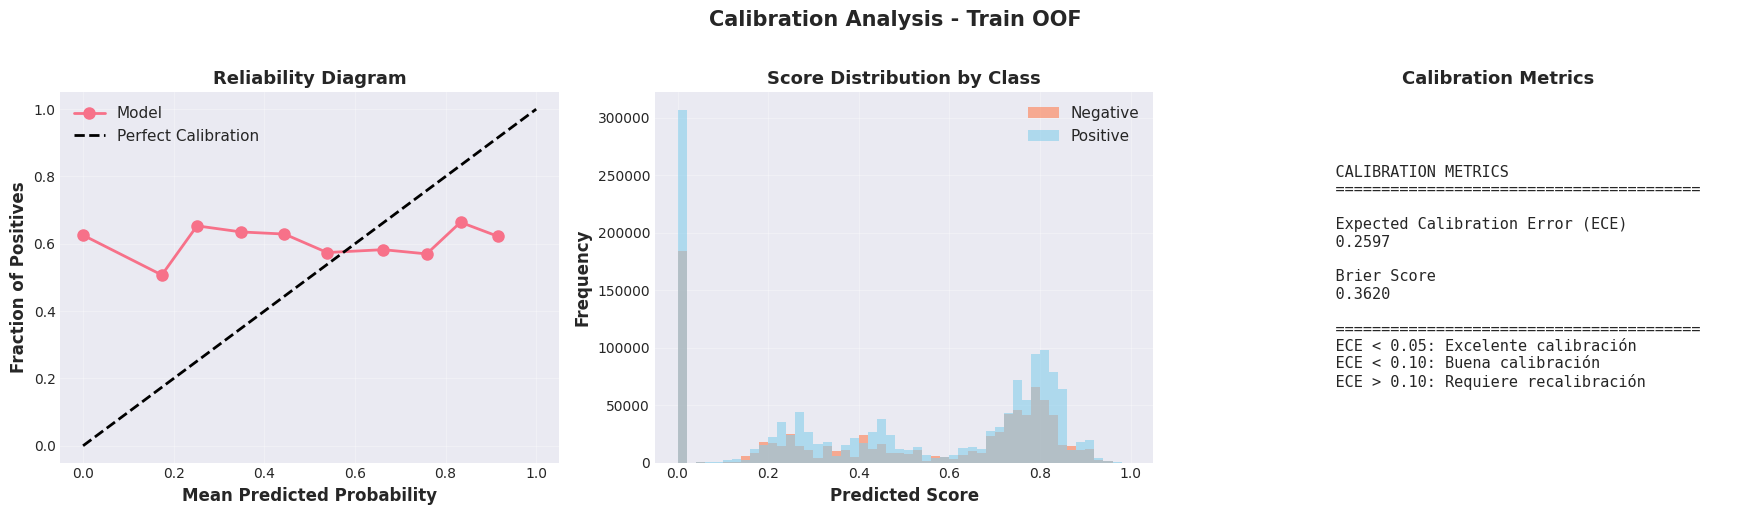


📊 Train OOF Calibration:
  ECE: 0.2597
  Brier: 0.3620


In [9]:
def plot_calibration_analysis(y_true, y_score, title='Calibration Analysis'):
    """
    Análisis completo de calibración del modelo incluyendo:
    - Reliability Diagram (curva de calibración)
    - Distribución de scores por clase
    - Métricas de calibración (ECE y Brier Score)
    
    Args:
        y_true: Array de labels verdaderas (0/1)
        y_score: Array de probabilidades predichas
        title: Título para el plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Reliability Diagram
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)
    axes[0].plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8, label='Model')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    axes[0].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].set_title('Reliability Diagram', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Score Distribution by Class
    axes[1].hist(y_score[y_true == 0], bins=50, alpha=0.6, label='Negative', color='coral')
    axes[1].hist(y_score[y_true == 1], bins=50, alpha=0.6, label='Positive', color='skyblue')
    axes[1].set_xlabel('Predicted Score', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].set_title('Score Distribution by Class', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Calibration Metrics
    ece = np.abs(prob_true - prob_pred).mean()
    brier = brier_score_loss(y_true, y_score)
    
    axes[2].axis('off')
    metrics_text = f"""
    CALIBRATION METRICS
    {'='*40}
    
    Expected Calibration Error (ECE)
    {ece:.4f}
    
    Brier Score
    {brier:.4f}
    
    {'='*40}
    ECE < 0.05: Excelente calibración
    ECE < 0.10: Buena calibración
    ECE > 0.10: Requiere recalibración
    """
    axes[2].text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
                 verticalalignment='center')
    axes[2].set_title('Calibration Metrics', fontsize=13, fontweight='bold')
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return {'ECE': ece, 'Brier': brier}

# EJECUTAR ANÁLISIS DE CALIBRACIÓN
print("\n" + "="*80)
print("ANÁLISIS DE CALIBRACIÓN - TRAIN OOF")
print("="*80)

cal_metrics_train = plot_calibration_analysis(
    y_train, 
    m_w30.oof_pred_,
    title='Calibration Analysis - Train OOF'
)

print(f"\n📊 Train OOF Calibration:")
print(f"  ECE: {cal_metrics_train['ECE']:.4f}")
print(f"  Brier: {cal_metrics_train['Brier']:.4f}")



THRESHOLD OPTIMIZATION - VALIDATION SET


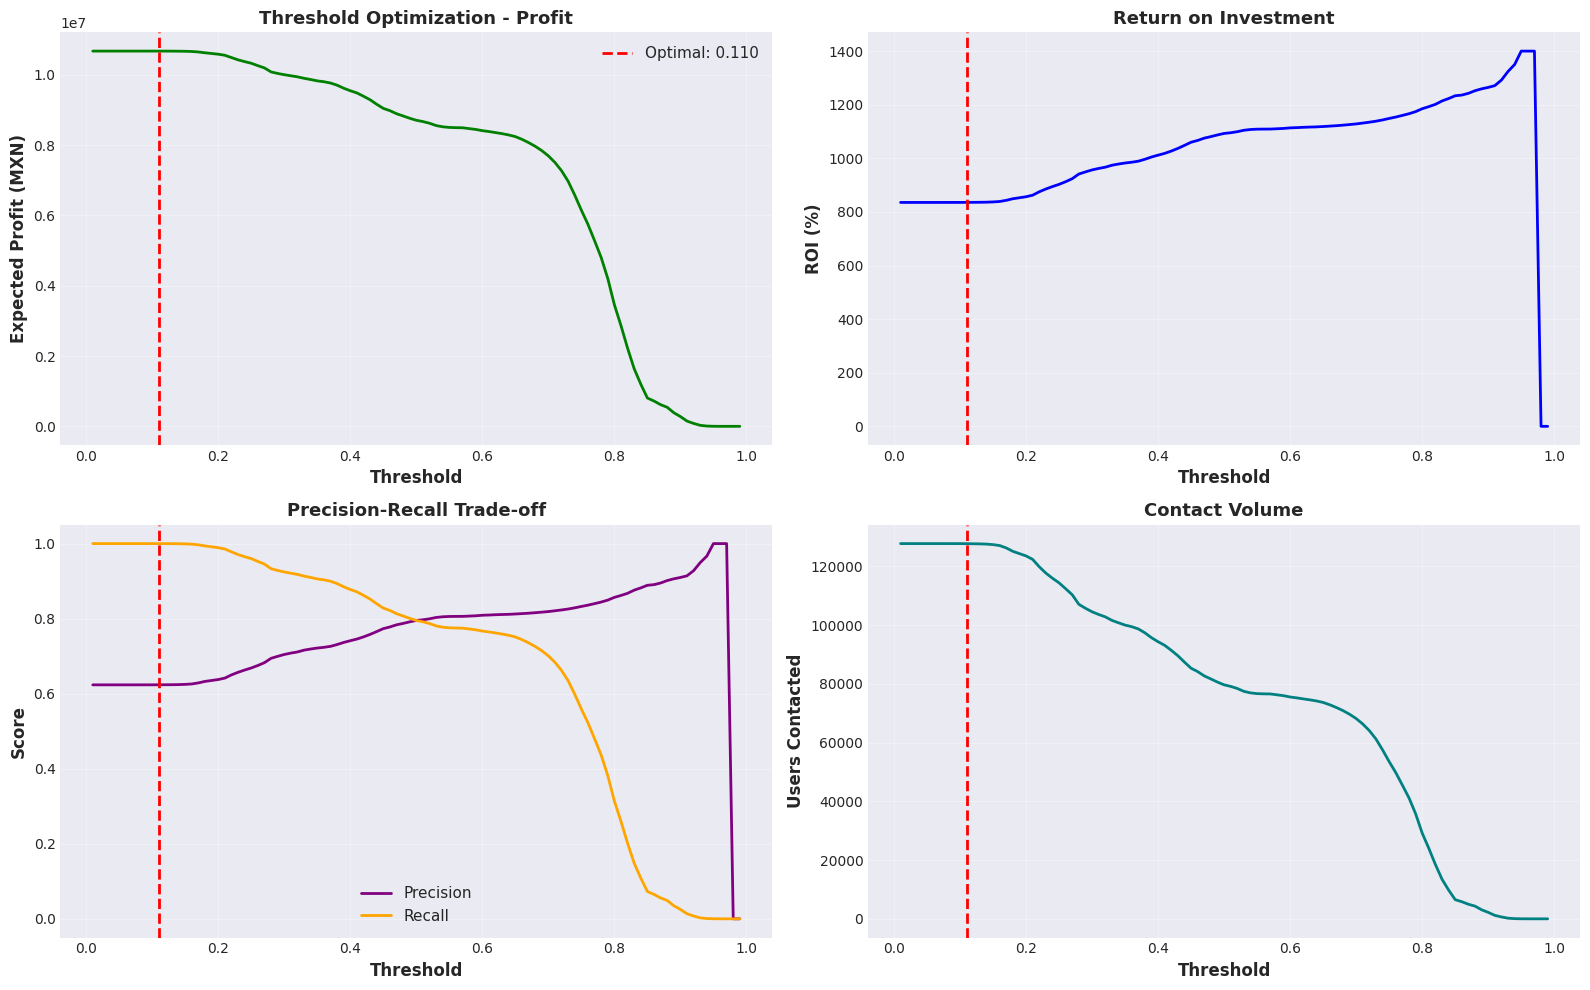


🎯 THRESHOLD ÓPTIMO: 0.1100

💰 MÉTRICAS DE NEGOCIO (Validation Set):
  Usuarios a contactar: 127,758
  True Positives: 79,683
  False Positives: 48,075
  Precision: 0.624
  Recall: 1.000

💵 IMPACTO ECONÓMICO:
  Revenue: $11,952,450 MXN
  Cost: $1,277,580 MXN
  Profit: $10,674,870 MXN
  ROI: 835.6%


In [10]:
def find_optimal_threshold(y_true, y_score, cost_per_contact=10, 
                          value_per_activation=150):
    """
    Encuentra el threshold óptimo que maximiza el profit esperado.
    
    Profit = (TP * value_per_activation) - ((TP + FP) * cost_per_contact)
    
    Args:
        y_true: Array de labels verdaderas
        y_score: Array de probabilidades predichas
        cost_per_contact: Costo de contactar a un usuario (MXN)
        value_per_activation: Valor de una activación exitosa (MXN)
    
    Returns:
        tuple: (optimal_threshold, max_profit, metrics_df)
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)
        
        # Confusion matrix
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        
        # Métricas de negocio
        contacted = tp + fp
        revenue = tp * value_per_activation
        cost = contacted * cost_per_contact
        profit = revenue - cost
        
        # ROI y otras métricas
        roi_pct = (profit / cost * 100) if cost > 0 else 0
        precision = tp / contacted if contacted > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        results.append({
            'threshold': thresh,
            'contacted': contacted,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'precision': precision,
            'recall': recall,
            'revenue_mxn': revenue,
            'cost_mxn': cost,
            'profit_mxn': profit,
            'roi_pct': roi_pct
        })
    
    df_results = pd.DataFrame(results)
    optimal_idx = df_results['profit_mxn'].idxmax()
    optimal_thresh = df_results.loc[optimal_idx, 'threshold']
    max_profit = df_results.loc[optimal_idx, 'profit_mxn']
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Profit vs Threshold
    ax1 = axes[0, 0]
    ax1.plot(df_results['threshold'], df_results['profit_mxn'], 
             linewidth=2, color='green')
    ax1.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2,
                label=f'Optimal: {optimal_thresh:.3f}')
    ax1.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Expected Profit (MXN)', fontsize=12, fontweight='bold')
    ax1.set_title('Threshold Optimization - Profit', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2. ROI vs Threshold
    ax2 = axes[0, 1]
    ax2.plot(df_results['threshold'], df_results['roi_pct'], 
             linewidth=2, color='blue')
    ax2.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('ROI (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Return on Investment', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision/Recall vs Threshold
    ax3 = axes[1, 0]
    ax3.plot(df_results['threshold'], df_results['precision'], 
             linewidth=2, label='Precision', color='purple')
    ax3.plot(df_results['threshold'], df_results['recall'], 
             linewidth=2, label='Recall', color='orange')
    ax3.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax3.set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # 4. Volume vs Threshold
    ax4 = axes[1, 1]
    ax4.plot(df_results['threshold'], df_results['contacted'], 
             linewidth=2, color='teal')
    ax4.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Users Contacted', fontsize=12, fontweight='bold')
    ax4.set_title('Contact Volume', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_thresh, max_profit, df_results

# EJECUTAR THRESHOLD OPTIMIZATION EN VALIDATION
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION - VALIDATION SET")
print("="*80)

# Generar predicciones en validation
fe_val = fb.transform(data_val)
X_val, y_val, meta_val = fe_val.X, fe_val.y, fe_val.meta
score_val = m_w30.predict_proba(X_val)

# Encontrar threshold óptimo
# AJUSTAR estos valores según tu negocio:
COST_PER_CONTACT = 10  # MXN - costo de SMS/push/campaña
VALUE_PER_ACTIVATION = 150  # MXN - valor estimado de una activación

optimal_thresh, max_profit, roi_results = find_optimal_threshold(
    y_val, 
    score_val,
    cost_per_contact=COST_PER_CONTACT,
    value_per_activation=VALUE_PER_ACTIVATION
)

# Métricas en threshold óptimo
optimal_row = roi_results[roi_results['threshold'] == optimal_thresh].iloc[0]

print(f"\n🎯 THRESHOLD ÓPTIMO: {optimal_thresh:.4f}")
print(f"\n💰 MÉTRICAS DE NEGOCIO (Validation Set):")
print(f"  Usuarios a contactar: {optimal_row['contacted']:,.0f}")
print(f"  True Positives: {optimal_row['tp']:,.0f}")
print(f"  False Positives: {optimal_row['fp']:,.0f}")
print(f"  Precision: {optimal_row['precision']:.3f}")
print(f"  Recall: {optimal_row['recall']:.3f}")
print(f"\n💵 IMPACTO ECONÓMICO:")
print(f"  Revenue: ${optimal_row['revenue_mxn']:,.0f} MXN")
print(f"  Cost: ${optimal_row['cost_mxn']:,.0f} MXN")
print(f"  Profit: ${optimal_row['profit_mxn']:,.0f} MXN")
print(f"  ROI: {optimal_row['roi_pct']:.1f}%")


In [11]:
def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros usando 3-fold TimeSeriesSplit para rapidez.
    """

    params = {
        # Tasa de aprendizaje: crucial para el rendimiento y la velocidad de convergencia.
        # Rango corregido: de 0.005 (low) a 0.2 (high)
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),

        # Complejidad del árbol (estructura):
        # max_leaf_nodes es el principal control de complejidad para este estimador.
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 127),

        # Regularización L2: penaliza la complejidad del modelo.
        'l2_regularization': trial.suggest_float('l2_regularization', 0.1, 10.0, log=True),

        # Requerimientos mínimos de muestras en hojas (para regularización).
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),

        # Profundidad máxima: puede limitar aún más la complejidad, aunque max_leaf_nodes suele ser suficiente.
        'max_depth': trial.suggest_int('max_depth', 3, 10),

        # Número de estimadores (árboles): se optimiza a través de early_stopping en lugar de un int fijo.
        'max_iter': 1000, # Se establece un valor alto y se usa early_stopping

        # Parámetros fijos o menos críticos (generalmente no se optimizan):
        'max_bins': 255, # Valor por defecto y máximo permitido, casi siempre óptimo.
        'loss': 'log_loss', # Función de pérdida típica para clasificación binaria/multiclase.

        # Parámetros de control de early stopping (útiles para optimizar 'max_iter'):
        'early_stopping': True,
        'validation_fraction': 0.2, # Proporción de datos para validación interna
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 10, 30), # Paciencia para early stopping

        # Semilla para reproducibilidad
        'random_state': CFG.random_state
    }
    
    # Simple 3-fold CV para rapidez
    tscv = TimeSeriesSplit(n_splits=3)
    time_order_train = pd.to_datetime(data_train[CFG.signup_date_col]).values
    
    # Ordenar datos
    order = np.argsort(time_order_train)
    X_sorted = X_train.iloc[order].reset_index(drop=True)
    y_sorted = y_train[order]
    
    scores = []
    
    for train_idx, val_idx in tscv.split(X_sorted):
        # Aplicar embargo simple
        train_dates = pd.to_datetime(time_order_train[order][train_idx])
        last_train = train_dates.max()
        embargo_cutoff = last_train + pd.Timedelta(days=CFG.embargo_days)
        
        val_dates = pd.to_datetime(time_order_train[order][val_idx])
        val_mask = val_dates >= embargo_cutoff
        val_idx_filtered = val_idx[val_mask]
        
        if len(val_idx_filtered) < 100:
            val_idx_filtered = val_idx  # Fallback si muy pocos datos
        
        # Entrenar
        model = HistGradientBoostingClassifier(**params)
        sw = compute_sample_weight(class_weight="balanced", y=y_sorted[train_idx])
        model.fit(X_sorted.iloc[train_idx], y_sorted[train_idx], sample_weight=sw)
        
        # Predecir
        pred = model.predict_proba(X_sorted.iloc[val_idx_filtered])[:, 1]
        score = average_precision_score(y_sorted[val_idx_filtered], pred)
        scores.append(score)
    
    return np.mean(scores)

# Crear estudio y optimizar
print("Iniciando optimización (50 trials)...")
print("Esto puede tomar varios minutos...\n")

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(),
    study_name='spin_activation_hpo'
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n✅ OPTIMIZACIÓN COMPLETADA\n")
print(f"🏆 Mejor Average Precision: {study.best_value:.4f}")
print(f"\n🎯 Mejores Hiperparámetros:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

# Visualizar resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Historia de optimización
ax1 = axes[0]
trials_values = [trial.value for trial in study.trials if trial.value is not None]
ax1.plot(trials_values, marker='o', linewidth=1.5)
ax1.axhline(study.best_value, color='red', linestyle='--', 
            label=f'Best: {study.best_value:.4f}')
ax1.set_xlabel('Trial', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Precision', fontsize=12, fontweight='bold')
ax1.set_title('Optimization History', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Importancia de parámetros
ax2 = axes[1]
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())
ax2.barh(params, importances)
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('Parameter Importance', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Guardar mejores parámetros para usar en modelo final
BEST_PARAMS = study.best_params
print("\n📝 Usar estos parámetros en _make_model() del modelo final")

[I 2025-11-24 20:58:49,111] A new study created in memory with name: spin_activation_hpo


Iniciando optimización (50 trials)...
Esto puede tomar varios minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[W 2025-11-24 21:00:00,542] Trial 0 failed with parameters: {'learning_rate': 0.047468254882101504, 'max_leaf_nodes': 53, 'l2_regularization': 5.2558328653430335, 'min_samples_leaf': 21, 'max_depth': 9, 'n_iter_no_change': 18} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/tmp/ipykernel_6671/1099170470.py", line 68, in objective
    model.fit(X_sorted.iloc[train_idx], y_sorted[train_idx], sample_weight=sw)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 935, in fit
    grower = TreeGrower(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_hist_gradient_boosting/grower.py", line 355,

KeyboardInterrupt: 

In [12]:
def lift_at_k(y_true, y_score, frac: float) -> float:
    n = len(y_true); k = max(1, int(n*frac))
    idx = np.argpartition(-y_score, k-1)[:k]
    top_pos = y_true[idx].sum()
    base_rate = y_true.mean()
    expected_pos = k*base_rate
    return float(top_pos/expected_pos) if expected_pos>0 else np.nan

class Activation30Model:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model_folds_: t.List[HistGradientBoostingClassifier] = []
        self.iso_folds_: t.List[IsotonicRegression] = []
        self.metrics_ = {}
        self.oof_pred_ = None
        self.feature_names_: t.List[str] = []

    def _make_model(self):
        return HistGradientBoostingClassifier(
            learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=50,
            l2_regularization=1.0, max_bins=255, random_state=self.cfg.random_state
        )
    def _apply_embargo(self, train_idx: np.ndarray, val_idx: np.ndarray, 
                       time_order: np.ndarray) -> t.Tuple[np.ndarray, np.ndarray]:
        """Purga registros del train/val que violen el embargo temporal"""
        if self.cfg.embargo_days == 0:
            return train_idx, val_idx

        # Convertir a pandas Timestamp para operaciones seguras
        train_dates = pd.to_datetime(time_order[train_idx])
        val_dates = pd.to_datetime(time_order[val_idx])

        # Última fecha de train
        last_train_date = train_dates.max()

        # Calcular embargo cutoff
        embargo_cutoff = last_train_date + pd.Timedelta(days=self.cfg.embargo_days)

        # Filtrar validación
        val_valid_mask = val_dates >= embargo_cutoff
        val_filtered = val_idx[val_valid_mask]

        # VALIDACIÓN CRÍTICA: Asegurar mínimo de muestras
        min_samples = 100  # mínimo razonable para HistGradientBoosting
        if len(val_filtered) < min_samples:
            print(f" WARNING: Embargo dejó {len(val_filtered)} muestras (< {min_samples}). "
                  f"Usando fold completo sin embargo.")
            return train_idx, val_idx

        removed = len(val_idx) - len(val_filtered)
        print(f"✓ Embargo aplicado: {removed} muestras removidas de validación "
              f"({removed/len(val_idx)*100:.1f}%)")

        return train_idx, val_filtered

def fit_cv(self, X: pd.DataFrame, y: np.ndarray, time_order: np.ndarray):
    """
    Entrena el modelo usando TimeSeriesSplit CV con embargo temporal
    y visualización de estabilidad por fold.
    """
    # Ordenar temporal
    order = np.argsort(time_order)
    X = X.iloc[order].reset_index(drop=True)
    y = y[order]
    time_order_sorted = pd.to_datetime(time_order[order])

    tss = TimeSeriesSplit(n_splits=self.cfg.n_splits)
    oof = np.zeros(len(X), dtype=float)
    self.model_folds_.clear()
    self.iso_folds_.clear()
    self.feature_names_ = X.columns.tolist()
    
    fold_metrics = []  # Track metrics per fold

    for f, (tr, va) in enumerate(tss.split(X)):
        # Embargo con fechas ya ordenadas
        tr, va = self._apply_embargo(tr, va, time_order_sorted)

        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y[tr], y[va]

        sw = compute_sample_weight(class_weight="balanced", y=ytr).astype("float32")

        m = self._make_model()
        m.fit(Xtr, ytr, sample_weight=sw)

        p_raw = m.predict_proba(Xva)[:, 1]
        iso = IsotonicRegression(out_of_bounds="clip").fit(p_raw, yva)
        p_cal = iso.transform(p_raw)
        oof[va] = p_cal

        self.model_folds_.append(m)
        self.iso_folds_.append(iso)
        
        # Calcular métricas del fold
        fold_ap = average_precision_score(yva, p_cal)
        fold_auc = roc_auc_score(yva, p_cal)
        fold_brier = brier_score_loss(yva, p_cal)
        
        fold_metrics.append({
            'fold': f + 1,
            'AP': fold_ap,
            'AUC': fold_auc,
            'Brier': fold_brier
        })
        
        print(f"[Fold {f+1}] AP={fold_ap:.4f} | AUC={fold_auc:.4f} | Brier={fold_brier:.4f}")

    self.oof_pred_ = oof
    self.metrics_ = {
        "OOF_AP": average_precision_score(y, oof),
        "OOF_AUC": roc_auc_score(y, oof),
        "OOF_Brier": brier_score_loss(y, oof),
        **{f"OOF_Lift@{int(fr*100)}%": lift_at_k(y, oof, fr) for fr in self.cfg.lift_fracs}
    }
    
    # NUEVO: Visualizar estabilidad por fold
    df_folds = pd.DataFrame(fold_metrics)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Métricas por fold
    ax1 = axes[0]
    ax1.plot(df_folds['fold'], df_folds['AP'], marker='o', linewidth=2, 
             markersize=8, label='AP', color='blue')
    ax1.plot(df_folds['fold'], df_folds['AUC'], marker='s', linewidth=2,
             markersize=8, label='AUC', color='green')
    ax1.axhline(df_folds['AP'].mean(), color='blue', linestyle='--', 
                alpha=0.5, label=f'Mean AP: {df_folds["AP"].mean():.4f}')
    ax1.axhline(df_folds['AUC'].mean(), color='green', linestyle='--',
                alpha=0.5, label=f'Mean AUC: {df_folds["AUC"].mean():.4f}')
    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('Temporal CV Stability - Performance', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot 2: Brier Score por fold
    ax2 = axes[1]
    ax2.plot(df_folds['fold'], df_folds['Brier'], marker='^', linewidth=2,
             markersize=8, label='Brier Score', color='coral')
    ax2.axhline(df_folds['Brier'].mean(), color='coral', linestyle='--',
                alpha=0.5, label=f'Mean: {df_folds["Brier"].mean():.4f}')
    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Brier Score', fontsize=12, fontweight='bold')
    ax2.set_title('Temporal CV Stability - Calibration', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de estabilidad
    print(f"\n📊 ESTABILIDAD TEMPORAL:")
    print(f"  AP  → Mean: {df_folds['AP'].mean():.4f} | Std: {df_folds['AP'].std():.4f}")
    print(f"  AUC → Mean: {df_folds['AUC'].mean():.4f} | Std: {df_folds['AUC'].std():.4f}")
    
    return self


    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        preds = np.zeros(len(X), dtype=float)
        for m, iso in zip(self.model_folds_, self.iso_folds_):
            preds += iso.transform(m.predict_proba(X)[:,1])
        return preds / max(1, len(self.model_folds_))


In [13]:
def _make_model(self):
    """
    Crea un HistGradientBoostingClassifier con los mejores hiperparámetros
    encontrados por Optuna (o valores por defecto si no se ejecutó HPO).
    """
    # Si existen BEST_PARAMS de Optuna, usarlos
    if 'BEST_PARAMS' in globals():
        return HistGradientBoostingClassifier(
            learning_rate=BEST_PARAMS['learning_rate'],
            max_leaf_nodes=BEST_PARAMS['max_leaf_nodes'],
            min_samples_leaf=BEST_PARAMS['min_samples_leaf'],
            l2_regularization=BEST_PARAMS['l2_regularization'],
            max_bins=BEST_PARAMS.get('max_bins', 255),
            random_state=self.cfg.random_state
        )
    else:
        # Valores por defecto
        return HistGradientBoostingClassifier(
            learning_rate=0.05, 
            max_leaf_nodes=31, 
            min_samples_leaf=50,
            l2_regularization=1.0, 
            max_bins=255, 
            random_state=self.cfg.random_state
        )

=== MÉTRICAS W30 (ACTIVACIÓN) ===

  Test_AP: 0.8321
  Test_AUC: 0.7740
  Test_Brier: 0.1776
  Test_Lift@1%: 1.4353
  Test_Lift@2%: 1.4157
  Test_Lift@5%: 1.3830
  Test_Lift@10%: 1.3673

=== COMPARACIÓN TRAIN / VALIDATION / TEST ===

  metric  train_oof  validation     test
      AP   0.769778    0.824033 0.832115
     AUC   0.660261    0.774002 0.774022
   Brier   0.279975    0.180176 0.177626
 Lift@1%   1.497498    1.460487 1.435300
 Lift@5%   1.443536    1.426440 1.382967
Lift@10%   1.405799    1.406862 1.367324

=== CALIBRACIÓN EN TEST SET ===


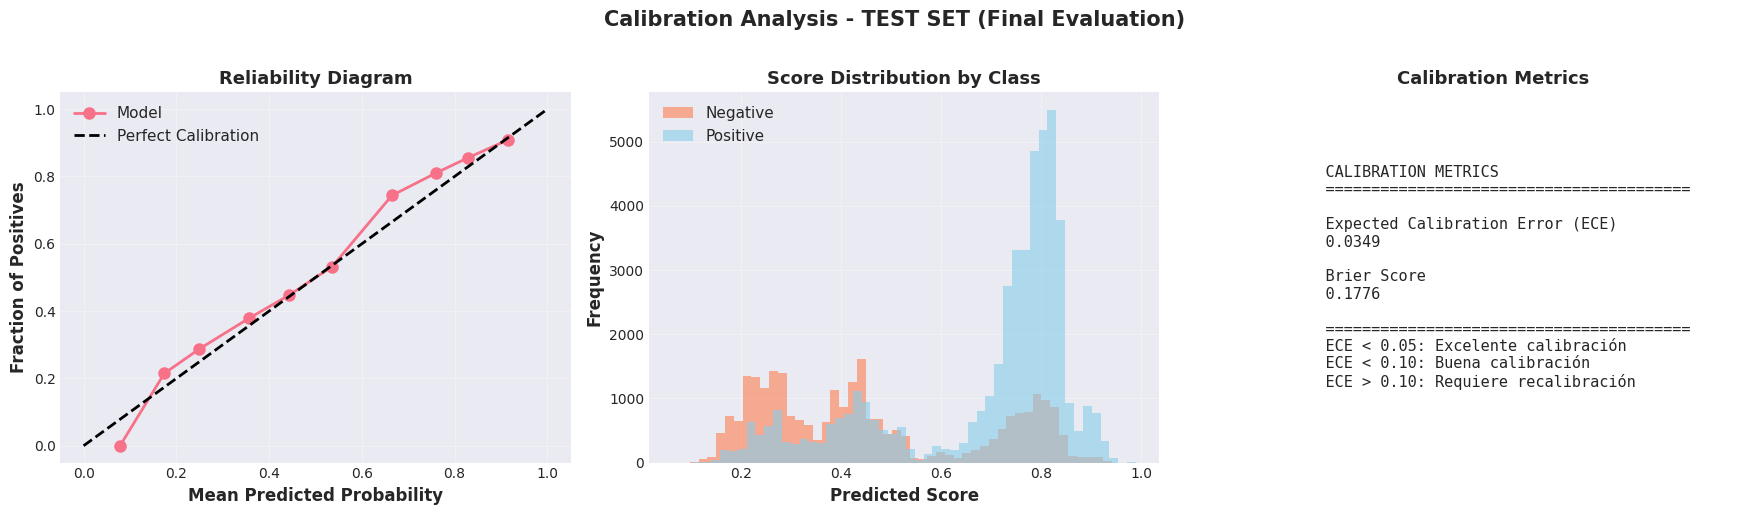


=== PERFORMANCE CON THRESHOLD ÓPTIMO (0.1100) ===

Confusion Matrix (Test Set):
          Pred 0  Pred 1
Actual 0       7   27314
Actual 1       1   48513

Classification Report (Test Set):
              precision    recall  f1-score   support

No Activated       0.88      0.00      0.00     27321
   Activated       0.64      1.00      0.78     48514

    accuracy                           0.64     75835
   macro avg       0.76      0.50      0.39     75835
weighted avg       0.72      0.64      0.50     75835


=== PROYECCIÓN DE NEGOCIO (TEST SET) ===
  Usuarios a contactar: 75,827
  Activaciones esperadas: 48,513
  Precision: 0.640

💰 IMPACTO ECONÓMICO PROYECTADO:
  Revenue: $7,276,950 MXN
  Cost: $758,270 MXN
  Profit: $6,518,680 MXN
  ROI: 859.7%

=== ANÁLISIS DE CONSISTENCIA ===
  AP drop Train→Val: -7.0%
  AP drop Train→Test: -8.1%
  ✅ Excelente generalización

=== EXPORTAR RESULTADOS FINALES ===
  comparison_df.to_csv('final_train_val_test_comparison.csv', index=False)
  # Usar

In [14]:
# Feature engineering en test
fe_test = fb.transform(data_test)
X_test, y_test, meta_test = fe_test.X, fe_test.y, fe_test.meta

# Predicciones W30
score_test_w30 = m_w30.predict_proba(X_test)

# Métricas de activación
test_metrics_w30 = {
    "Test_AP": average_precision_score(y_test, score_test_w30),
    "Test_AUC": roc_auc_score(y_test, score_test_w30),
    "Test_Brier": brier_score_loss(y_test, score_test_w30),
    **{f"Test_Lift@{int(fr*100)}%": lift_at_k(y_test, score_test_w30, fr) 
       for fr in CFG.lift_fracs}
}

print("=== MÉTRICAS W30 (ACTIVACIÓN) ===\n")
for k, v in test_metrics_w30.items():
    print(f"  {k}: {v:.4f}")

# Comparación Train/Val/Test
comparison_df = pd.DataFrame({
    'metric': ['AP', 'AUC', 'Brier', 'Lift@1%', 'Lift@5%', 'Lift@10%'],
    'train_oof': [
        m_w30.metrics_['OOF_AP'],
        m_w30.metrics_['OOF_AUC'],
        m_w30.metrics_['OOF_Brier'],
        m_w30.metrics_['OOF_Lift@1%'],
        m_w30.metrics_['OOF_Lift@5%'],
        m_w30.metrics_['OOF_Lift@10%']
    ],
    'validation': [
        average_precision_score(y_val, score_val),
        roc_auc_score(y_val, score_val),
        brier_score_loss(y_val, score_val),
        lift_at_k(y_val, score_val, 0.01),
        lift_at_k(y_val, score_val, 0.05),
        lift_at_k(y_val, score_val, 0.10)
    ],
    'test': [
        test_metrics_w30['Test_AP'],
        test_metrics_w30['Test_AUC'],
        test_metrics_w30['Test_Brier'],
        test_metrics_w30['Test_Lift@1%'],
        test_metrics_w30['Test_Lift@5%'],
        test_metrics_w30['Test_Lift@10%']
    ]
})

print("\n=== COMPARACIÓN TRAIN / VALIDATION / TEST ===\n")
print(comparison_df.to_string(index=False))

# Análisis de calibración en test
print("\n=== CALIBRACIÓN EN TEST SET ===")
cal_metrics_test = plot_calibration_analysis(
    y_test, 
    score_test_w30,
    title='Calibration Analysis - TEST SET (Final Evaluation)'
)

# Aplicar threshold óptimo en test
y_pred_test_optimal = (score_test_w30 >= optimal_thresh).astype(int)

print(f"\n=== PERFORMANCE CON THRESHOLD ÓPTIMO ({optimal_thresh:.4f}) ===")
print(f"\nConfusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test, y_pred_test_optimal)
cm_df = pd.DataFrame(cm_test, 
                      index=['Actual 0', 'Actual 1'],
                      columns=['Pred 0', 'Pred 1'])
print(cm_df)

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test_optimal, 
                           target_names=['No Activated', 'Activated']))

# Análisis de ROI en test
tp_test = ((y_pred_test_optimal == 1) & (y_test == 1)).sum()
fp_test = ((y_pred_test_optimal == 1) & (y_test == 0)).sum()
contacted_test = tp_test + fp_test
revenue_test = tp_test * VALUE_PER_ACTIVATION
cost_test = contacted_test * COST_PER_CONTACT
profit_test = revenue_test - cost_test
roi_test = (profit_test / cost_test * 100) if cost_test > 0 else 0

print(f"\n=== PROYECCIÓN DE NEGOCIO (TEST SET) ===")
print(f"  Usuarios a contactar: {contacted_test:,}")
print(f"  Activaciones esperadas: {tp_test:,}")
print(f"  Precision: {tp_test/contacted_test:.3f}")
print(f"\n💰 IMPACTO ECONÓMICO PROYECTADO:")
print(f"  Revenue: ${revenue_test:,.0f} MXN")
print(f"  Cost: ${cost_test:,.0f} MXN")
print(f"  Profit: ${profit_test:,.0f} MXN")
print(f"  ROI: {roi_test:.1f}%")

# Verificar consistencia entre splits
print("\n=== ANÁLISIS DE CONSISTENCIA ===")
ap_drop_val = (comparison_df.loc[0, 'train_oof'] - comparison_df.loc[0, 'validation']) / comparison_df.loc[0, 'train_oof'] * 100
ap_drop_test = (comparison_df.loc[0, 'train_oof'] - comparison_df.loc[0, 'test']) / comparison_df.loc[0, 'train_oof'] * 100

print(f"  AP drop Train→Val: {ap_drop_val:.1f}%")
print(f"  AP drop Train→Test: {ap_drop_test:.1f}%")

if abs(ap_drop_test) < 10:
    print("  ✅ Excelente generalización")
elif abs(ap_drop_test) < 20:
    print("  ✓ Buena generalización")
else:
    print("  ⚠️  Revisar: posible overfitting o data drift")

# Guardar resultados finales
print("\n=== EXPORTAR RESULTADOS FINALES ===")
print("  comparison_df.to_csv('final_train_val_test_comparison.csv', index=False)")
print("  # Usar score_test_w30 para scoring en producción")

print("\n" + "="*80)
print("✅ EVALUACIÓN FINAL COMPLETADA")
print("="*80)

In [27]:
from pathlib import Path
from dataclasses import asdict
import json
import joblib

ARTIFACTS_DIR = Path("Model_1.2.0/artifacts")


def save_training_artifacts(artifacts_dir: Path = ARTIFACTS_DIR) -> None:
    artifacts_dir = Path(artifacts_dir)
    artifacts_dir.mkdir(parents=True, exist_ok=True)
#CONFIG + INFO DE LOS SPLITS

    cfg_dict = asdict(CFG)

    train_info = {
        "project_id": CFG.project_id,
        "table_fqn": CFG.table_fqn,
        "label_col": CFG.label_col,
        "signup_ts_col": CFG.signup_ts_col,
        "signup_date_col": CFG.signup_date_col,
        "n_total": int(len(data_raw)),
        "n_train": int(len(data_train)),
        "n_val": int(len(data_val)),
        "n_test": int(len(data_test)),
        "pos_rate_total": float(data_raw[CFG.label_col].mean()),
        "pos_rate_train": float(data_train[CFG.label_col].mean()),
        "pos_rate_val": float(data_val[CFG.label_col].mean()),
        "pos_rate_test": float(data_test[CFG.label_col].mean()),
        "train_date_min": str(data_train[CFG.signup_date_col].min()),
        "train_date_max": str(data_train[CFG.signup_date_col].max()),
        "val_date_min": str(data_val[CFG.signup_date_col].min()),
        "val_date_max": str(data_val[CFG.signup_date_col].max()),
        "test_date_min": str(data_test[CFG.signup_date_col].min()),
        "test_date_max": str(data_test[CFG.signup_date_col].max()),
    }

    with open(artifacts_dir / "config.json", "w") as f:
        json.dump(cfg_dict, f, indent=2, default=str)

    with open(artifacts_dir / "train_val_test_info.json", "w") as f:
        json.dump(train_info, f, indent=2, default=str)


        # 2) FEATURE ENGINEERING / TRANSFORMACIÓN

    # FeatureBuilder 
    joblib.dump(fb, artifacts_dir / "feature_builder.pkl")

    fe_meta = {
        "numeric_cols": getattr(fb, "numeric_cols_", []),
        "state_ohe_cols": getattr(fb, "ohe_states_", []),
        "scaler": type(getattr(fb, "scaler_", None)).__name__
        if getattr(fb, "scaler_", None) is not None
        else None,
    }

    with open(artifacts_dir / "feature_builder_meta.json", "w") as f:
        json.dump(fe_meta, f, indent=2, default=str)

    # MODEL 30D (ACTIVACIÓN BINARIA W30)
    # Model complete (folds + calibradores + métricas OOF)
    joblib.dump(m_w30, artifacts_dir / "model_activation_30d.pkl")

    # Feature names usados por el modelo
    feature_names = list(getattr(m_w30, "feature_names_", []))
    if not feature_names:
        # fallback limpio
        feature_names = list(X_train.columns)

    activation_summary = {
        "model_type": "HistGradientBoostingClassifier + Isotonic (k-fold)",
        "n_folds": len(m_w30.model_folds_),
        "base_params": m_w30.model_folds_[0].get_params()
        if len(m_w30.model_folds_) > 0
        else None,
        "metrics_oof": m_w30.metrics_,          # AP, AUC, Brier, Lift@k (train OOF)
        "metrics_holdout": holdout_metrics,     # AP, AUC, Brier, Lift@k (holdout)
        "feature_names": feature_names,
        "label_col": CFG.label_col,
        "train_size": int(len(X_train)),
        "holdout_size": int(len(X_holdout)),
        "pos_rate_train": float(y_train.mean()),
        "pos_rate_holdout": float(y_holdout.mean()),
    }

    with open(artifacts_dir / "model_activation_30d_summary.json", "w") as f:
        json.dump(activation_summary, f, indent=2, default=str)

    # MODEL  TyPE of TRANSACTION (Cash_In/SPEI/P2P)
    joblib.dump(m_tx, artifacts_dir / "model_tx_type.pkl")

    tx_params = m_tx.model_.get_params() if getattr(m_tx, "model_", None) is not None else None

    tx_summary = {
        "model_type": "HistGradientBoostingClassifier (multiclase)",
        "classes": {int(k): v for k, v in TX_TYPE_NAMES.items()},
        "base_params": tx_params,
    }

    with open(artifacts_dir / "model_tx_type_summary.json", "w") as f:
        json.dump(tx_summary, f, indent=2, default=str)

    # PREDICCIONES COMPLETAS A CSV
    #    (score 30d + recomendación de canal)
    preds_path = artifacts_dir / "preds_w30_tx.csv"
    preds_w30_tx.to_csv(preds_path, index=False)
     # ----------------------------------------------
    # 6) README SENCILLO (opcional pero útil)
    # ----------------------------------------------
    readme = f"""# Model 1.2.0 – Activación 30d + Tipo de Transacción

    Este folder contiene los artefactos de entrenamiento del modelo de Activación 30d
    y el modelo multiclase de tipo de primera transacción.

    Archivos clave:
    - config.json                         → Configuración de entrenamiento (tabla origen, columnas, seeds, etc.)
    - train_val_test_info.json            → Tamaños, fechas y tasas de activación por split.
    - feature_builder.pkl                 → Objeto FeatureBuilder (feature engineering + scaler).
    - feature_builder_meta.json           → Listas de columnas numéricas y OHE, tipo de scaler.
    - model_activation_30d.pkl            → Modelo W30 entrenado (folds + calibradores).
    - model_activation_30d_summary.json   → Métricas OOF/Holdout + features usadas.
    - model_tx_type.pkl                   → Modelo multiclase Cash_In / SPEI / P2P.
    - model_tx_type_summary.json          → Hiperparámetros y mapping de clases.
    - preds_w30_tx.csv                    → Predicciones por usuario (scores + recomendación de canal).

    ARTIFACT_VERSION = "1.1.4"
    ARTIFACTS_DIR = "{artifacts_dir}"
    """
    with open(artifacts_dir / "README.md", "w") as f:
        f.write(readme)

        print(f"✅ Artefactos guardados en: {artifacts_dir.resolve()}")
        print("   - config.json")
        print("   - train_val_test_info.json")
        print("   - feature_builder.pkl + feature_builder_meta.json")
        print("   - model_activation_30d.pkl + model_activation_30d_summary.json")
        print("   - model_tx_type.pkl + model_tx_type_summary.json")
        print(f"   - preds_w30_tx.csv")
        print("   - README.md")
# Llama esto al final del notebook cuando ya entrenaste todo:
    save_training_artifacts()

NameError: name 'artifacts_dir' is not defined

# data viz

In [22]:
y_true = y_all  # Labels verdaderos (train + holdout)
y_score = score_w30_all  # Scores del modelo W30
meta = meta_all  # Metadata completa
time_order = meta_all["signup_date"].values  # Para PSI
data = pd.concat([data_train, data_holdout], axis=0, ignore_index=True)

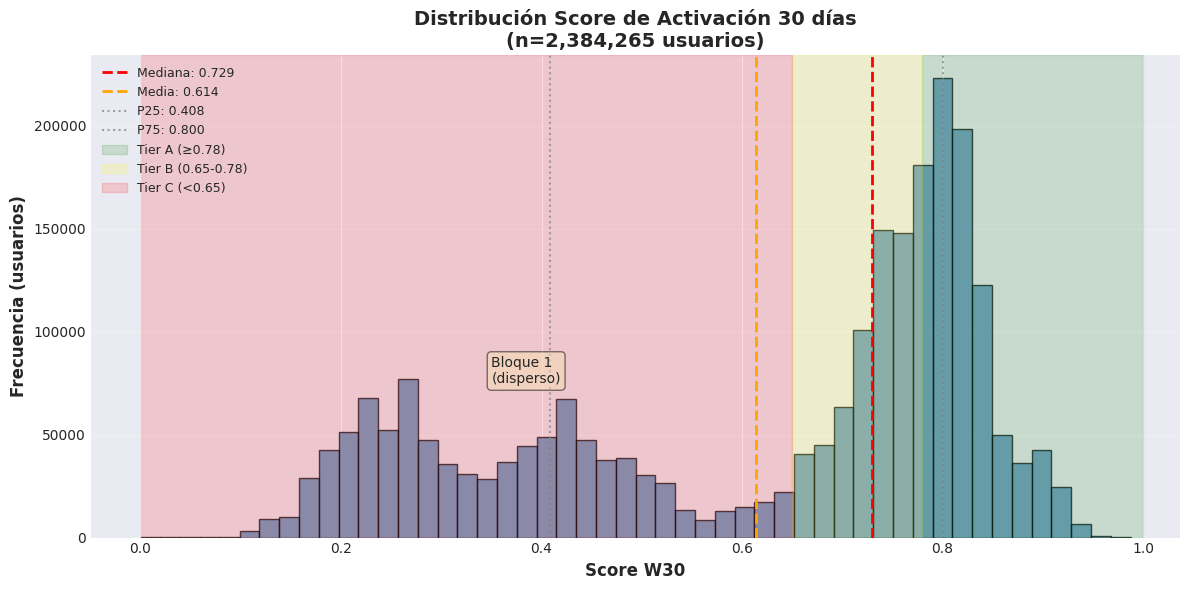

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

# Histograma con más bins
ax.hist(y_score, bins=50, alpha=0.7, color='steelblue', edgecolor='black')

# Estadísticas descriptivas (¡CORREGIDAS!)
mean_val = y_score.mean()
median_val = np.median(y_score)            # <--- CORREGIDO
p25 = np.quantile(y_score, 0.25)          # <--- CORREGIDO
p75 = np.quantile(y_score, 0.75)          # <--- CORREGIDO

# Líneas verticales con anotaciones
ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.3f}')
ax.axvline(mean_val, color='orange', linestyle='--', linewidth=2, label=f'Media: {mean_val:.3f}')
ax.axvline(p25, color='gray', linestyle=':', alpha=0.7, label=f'P25: {p25:.3f}')
ax.axvline(p75, color='gray', linestyle=':', alpha=0.7, label=f'P75: {p75:.3f}')

# Marcar regiones de tiers propuestos
ax.axvspan(0.78, 1.0, alpha=0.15, color='green', label='Tier A (≥0.78)')
ax.axvspan(0.65, 0.78, alpha=0.15, color='yellow', label='Tier B (0.65-0.78)')
ax.axvspan(0.0, 0.65, alpha=0.15, color='red', label='Tier C (<0.65)')

# Anotaciones de los bloques bimodales
ax.annotate('Bloque 1\n(disperso)', xy=(0.35, 75000), fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.annotate('Bloque 2\n(concentrado)', xy=(0.80, 250000), fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax.set_xlabel('Score W30', fontsize=12, fontweight='bold')
ax.set_ylabel('Frecuencia (usuarios)', fontsize=12, fontweight='bold')
# Asumo que la variable 'scores_w30' era 'y_score'
ax.set_title(f'Distribución Score de Activación 30 días\n(n={len(y_score):,} usuarios)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show() # Añadido para mostrar el gráfico

In [ ]:
# 1. Definimos la rejilla 3x2 (de la Versión 2)
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# 2. Definimos los datos a iterar (de la Versión 1)
score_columns = [
    ("score_cash_in", "Cash_In", "steelblue"),
    ("score_spei", "SPEI", "coral"),
    ("score_p2p", "P2P", "seagreen")
]

# 3. Iteramos usando la lógica de la Versión 1
for idx, (score_col, name, color) in enumerate(score_columns):
    
    # Seleccionamos los subplots correctos para esta fila
    ax_hist = axes[idx, 0]
    ax_box = axes[idx, 1]
    
    # Obtenemos los datos como un array de NumPy (de la Versión 1)
    # Asumimos que preds_w30_tx es un DataFrame de Pandas
    scores = preds_w30_tx[score_col].values
    
    # 4. Calculamos estadísticas (usando NumPy para seguridad)
    mean_val = np.mean(scores)
    median_val = np.median(scores)
    std_val = np.std(scores)
    p25 = np.quantile(scores, 0.25)
    p75 = np.quantile(scores, 0.75)
    min_val = np.min(scores)
    max_val = np.max(scores)

    # --- COLUMNA 1: Histograma (Estilo de Versión 2) ---
    ax_hist.hist(scores, bins=50, alpha=0.7, color=color, edgecolor='black')
    
    # Líneas verticales de estadísticas
    ax_hist.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.3f}')
    ax_hist.axvline(mean_val, color='darkred', linestyle='-', linewidth=2, label=f'Media: {mean_val:.3f}')
    ax_hist.axvline(p25, color='gray', linestyle=':', alpha=0.7)
    ax_hist.axvline(p75, color='gray', linestyle=':', alpha=0.7)
    
    # Rango dinámico como sombra
    ax_hist.axvspan(min_val, max_val, alpha=0.05, color=color)
    
    # Títulos y etiquetas
    ax_hist.set_xlabel(f'Score {name}', fontweight='bold')
    ax_hist.set_ylabel('Frecuencia')
    ax_hist.set_title(f'{name} | n={len(scores):,} | Rango: [{min_val:.3f}, {max_val:.3f}]', 
                      fontweight='bold')
    ax_hist.legend(fontsize=8)
    ax_hist.grid(axis='y', alpha=0.3)
    
    # --- COLUMNA 2: Boxplot con Violín (Estilo de Versión 2) ---
    parts = ax_box.violinplot([scores], positions=[0], widths=0.7, showmeans=True, showmedians=True)
    
    # Colorear el violín
    parts['bodies'][0].set_facecolor(color)
    parts['bodies'][0].set_alpha(0.7)
    
    # Títulos y etiquetas
    ax_box.set_ylabel('Score')
    ax_box.set_title(f'Distribución completa', fontweight='bold')
    ax_box.set_xticks([]) # Ocultar eje X
    ax_box.grid(axis='y', alpha=0.3)
    
    # Anotaciones de percentiles
    ax_box.text(0.15, p25, f'P25: {p25:.3f}', fontsize=8)
    ax_box.text(0.15, p75, f'P75: {p75:.3f}', fontsize=8)
    ax_box.text(0.15, median_val, f'P50: {median_val:.3f}', fontsize=8, fontweight='bold')

# 5. Ajuste final
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

# 1. Definimos los datos a iterar (basado en 'Old code')
canales_config = [
    ("score_cash_in", "Cash_In", "steelblue"),
    ("score_spei", "SPEI", "coral"),
    ("score_p2p", "P2P", "mediumseagreen")
]

table_data = []

# 2. Iteramos usando los datos del DataFrame
for score_col, canal, color in canales_config:
    
    # Obtenemos los datos como un array de NumPy
    scores = preds_w30_tx[score_col].values
    
    # 3. KDE (de 'New version')
    kde = stats.gaussian_kde(scores)
    x_range = np.linspace(0, 1, 1000)
    density = kde(x_range)
    
    # Plot
    ax.plot(x_range, density, label=canal, color=color, linewidth=2.5, alpha=0.8)
    ax.fill_between(x_range, density, alpha=0.15, color=color)
    
    # 4. Calculamos estadísticas (con funciones de NumPy)
    p50 = np.median(scores)
    p75 = np.quantile(scores, 0.75)
    p90 = np.quantile(scores, 0.90)
    # Calculamos el % > 0.6 dinámicamente
    pct_high = np.mean(scores > 0.6) * 100 
    
    # 5. Lógica de anotaciones (de 'New version', pero con etiqueta dinámica)
    if canal == 'Cash_In':
        mask = x_range >= 0.6
        # Usamos la variable 'pct_high' en lugar de un valor hardcodeado
        ax.fill_between(x_range[mask], density[mask], alpha=0.3, color='gold', 
                        label=f'{canal} tail >0.6 ({pct_high:.1f}% usuarios)')
        
        # Marcar los dos picos (coordenadas de 'New version')
        pico1_x = 0.33 # aproximado
        pico2_x = 0.68 # aproximado
        ax.annotate('Pico 1', xy=(pico1_x, kde(pico1_x)[0]), 
                    xytext=(pico1_x - 0.1, kde(pico1_x)[0] + 0.5),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        ax.annotate('Pico 2\n(tail)', xy=(pico2_x, kde(pico2_x)[0]), 
                    xytext=(pico2_x + 0.1, kde(pico2_x)[0] + 0.5),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # 6. Líneas de percentiles
    ax.axvline(p50, color=color, linestyle=':', alpha=0.5, linewidth=1, label=f'{canal} P50')
    ax.axvline(p75, color=color, linestyle='--', alpha=0.5, linewidth=1)
    ax.axvline(p90, color=color, linestyle='-.', alpha=0.5, linewidth=1)

    # 7. Preparamos datos para la tabla
    table_data.append([canal, f'{p50:.3f}', f'{p75:.3f}', f'{p90:.3f}', f'{pct_high:.1f}%'])

# --- Resto del formato (de 'New version') ---

# Línea vertical en 0.6 (threshold importante)
ax.axvline(0.6, color='red', linestyle='-', linewidth=2, alpha=0.3, label='Threshold 0.6')

ax.set_xlabel('Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Densidad (KDE)', fontsize=13, fontweight='bold')
ax.set_title('Distribución de Densidad Superpuesta (KDE)\nComparación entre Canales de Activación', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9) # Ajustado fontsize
ax.grid(axis='y', alpha=0.3)
ax.set_xlim(0, 1)

# Tabla de estadísticas
table = ax.table(cellText=table_data, 
                 colLabels=['Canal', 'P50', 'P75', 'P90', '% >0.6'],
                 cellLoc='center', loc='upper left',
                 bbox=[0.02, 0.65, 0.25, 0.25]) # Ajustado Bbox
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

# 1. Definición de la configuración (de ambas versiones)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
# Unimos la info de 'score_columns' (Old) y 'markers' (New)
canales_config = [
    ("score_cash_in", "Cash_In", "steelblue", "o"),
    ("score_spei", "SPEI", "coral", "s"),
    ("score_p2p", "P2P", "mediumseagreen", "^")
]

table_data = [] # Para la tabla al final

# 2. Iteramos usando la lógica del 'Old Code'
for score_col, canal, color, marker in canales_config:
    
    # Obtenemos datos como array de NumPy (de 'Old Code')
    scores = preds_w30_tx[score_col].values
    
    # Calculamos percentiles (de 'Old Code', ¡esto es lo correcto para NumPy!)
    pct_values = [np.percentile(scores, p) for p in percentiles]
    
    # Graficamos (con el estilo de 'New version')
    ax.plot(percentiles, pct_values, label=canal, color=color, 
            marker=marker, markersize=8, linewidth=2.5, alpha=0.8)

    # 3. Preparamos los datos para la tabla (de 'New version')
    row = [canal]
    table_percentiles = [25, 50, 75, 90, 95, 99]
    for p in table_percentiles:
        # Usamos np.percentile (corregido) en lugar de .quantile
        row.append(f'{np.percentile(scores, p):.3f}') 
    table_data.append(row)

# --- 4. Estilos y Anotaciones (de 'New version') ---

# Sombrear región de divergencia
ax.axvspan(75, 99, alpha=0.1, color='yellow', label='Región de divergencia')

# Líneas horizontales de referencia
ax.axhline(0.6, color='red', linestyle='--', linewidth=1.5, alpha=0.4, label='Threshold Alto (0.6)')
ax.axhline(0.4, color='orange', linestyle='--', linewidth=1.5, alpha=0.4, label='Threshold Medio (0.4)')

# 5. Anotación de Gap (Corregida para que funcione)
# Para esta anotación, sí necesitamos los datos específicos
scores_cashin_arr = preds_w30_tx['score_cash_in'].values
scores_spei_arr = preds_w30_tx['score_spei'].values

# Calculamos los P99 usando NumPy
p99_cashin = np.percentile(scores_cashin_arr, 99)
p99_spei = np.percentile(scores_spei_arr, 99)
gap_p99 = p99_cashin - p99_spei

ax.annotate(f'Gap en P99:\n{gap_p99:.3f}', 
            xy=(99, p99_cashin),  # Usamos el P99 de Cash_In calculado
            xytext=(95, 0.85),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Marcar punto de divergencia (P75)
ax.axvline(75, color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.annotate('Inicio de\nDivergencia', xy=(75, 0.1), fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.6))

# 6. Formato final del gráfico
ax.set_xlabel('Percentil', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Curva de Percentiles por Tipo de Transacción\n(Capacidad Discriminativa por Canal)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)

# 7. Tabla de valores (de 'New version')
table = ax.table(cellText=table_data, 
                 colLabels=['Canal', 'P25', 'P50', 'P75', 'P90', 'P95', 'P99'],
                 cellLoc='center', loc='bottom',
                 bbox=[0.1, -0.3, 0.8, 0.2]) # Ajustado un poco el Bbox
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Ajustamos el layout para dar espacio a la tabla de abajo
plt.subplots_adjust(bottom=0.25)
plt.show()

In [ ]:
# 1. Definir la estructura de la 'New Version'
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 2. Definir los rangos (del 'New Version')
rangos = {
    'Muy Bajo': (0.0, 0.2),
    'Bajo': (0.2, 0.4),
    'Medio': (0.4, 0.6),
    'Alto': (0.6, 0.8),
    'Muy Alto': (0.8, 1.0)
}

# --- 3. SUBPLOT 1: Absolutos (log scale) ---
ax1 = axes[0]
x = np.arange(len(rangos))
width = 0.25  # Ancho de la barra

# 4. Iterar usando la lógica del 'Old Code'
for idx, (score_col, canal, color) in enumerate(score_columns):
    
    # Extraer datos del DataFrame (del 'Old Code')
    scores = preds_w30_tx[score_col].values
    
    counts = []
    # Calcular cuentas (lógica de 'New Version')
    for rango_name, (min_val, max_val) in rangos.items():
        count = ((scores >= min_val) & (scores < max_val)).sum()
        counts.append(count)
    
    # Graficar barras (lógica de 'New Version')
    offset = (idx - 1) * width  # Centrar las 3 barras (idx 0, 1, 2 -> -1, 0, 1)
    bars = ax1.bar(x + offset, counts, width, label=canal, color=color, alpha=0.8)
    
    # Etiquetas en barras (lógica de 'New Version')
    for bar, count in zip(bars, counts):
        if count > 1000: # Umbral para no saturar
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                     f'{count:,}', ha='center', va='bottom', fontsize=8)

# 5. Formato del Subplot 1 (de 'New Version')
ax1.set_yscale('log')
ax1.set_ylabel('Número de Usuarios (escala log)', fontsize=12, fontweight='bold')
ax1.set_title('Volumen de Usuarios por Rango de Score y Canal (Valores Absolutos)', 
              fontsize=13, fontweight='bold')
ax1.set_xticks(x) # Centrado en x
ax1.set_xticklabels([f'{k}\n({v[0]:.1f}-{v[1]:.1f})' for k, v in rangos.items()])
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3, which='both')

# --- 6. SUBPLOT 2: Porcentajes ---
ax2 = axes[1]

# 7. Iterar DE NUEVO usando la lógica del 'Old Code'
for idx, (score_col, canal, color) in enumerate(score_columns):
    
    # Extraer datos del DataFrame
    scores = preds_w30_tx[score_col].values
    
    percentages = []
    # Calcular porcentajes (lógica de 'New Version')
    for rango_name, (min_val, max_val) in rangos.items():
        # .mean() sobre un booleano es la forma más rápida de sacar porcentaje
        pct = ((scores >= min_val) & (scores < max_val)).mean() * 100
        percentages.append(pct)
    
    # Graficar barras
    offset = (idx - 1) * width # Mismo offset para centrar
    bars = ax2.bar(x + offset, percentages, width, label=canal, color=color, alpha=0.8)
    
    # Etiquetas en barras
    for bar, pct in zip(bars, percentages):
        if pct > 1:  # Solo mostrar si >1%
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, # Centrado
                     f'{pct:.1f}%', ha='center', va='center',
                     fontsize=9, fontweight='bold', color='white')

# 8. Formato del Subplot 2 (de 'New Version')
ax2.set_ylabel('Porcentaje de Usuarios (%)', fontsize=12, fontweight='bold')
ax2.set_title('Distribución Porcentual de Usuarios por Rango y Canal', 
              fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{k}\n({v[0]:.1f}-{v[1]:.1f})' for k, v in rangos.items()])
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

# Línea de referencia 50%
ax2.axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

# 1. Definimos la configuración (de 'New Version')
positions = [1, 2, 3]
canales = ['Cash_In', 'SPEI', 'P2P']
colors = ['steelblue', 'coral', 'mediumseagreen']

# 2. Creamos la lista de datos (de 'Old Version', usando .values)
#    Usamos .values para ser consistentes y asegurar que son arrays de NumPy
scores_list = [
    preds_w30_tx['score_cash_in'].values,
    preds_w30_tx['score_spei'].values,
    preds_w30_tx['score_p2p'].values
]

# 3. Violin plots (de 'New Version')
parts = ax.violinplot(scores_list, positions=positions, widths=0.7,
                      showmeans=True, showmedians=True, showextrema=True)

# Colorear cada violin
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.6)

# 4. Agregar boxplots pequeños encima (de 'New Version')
bp = ax.boxplot(scores_list, positions=positions, widths=0.2,
                patch_artist=True, showfliers=False,
                boxprops=dict(facecolor='white', alpha=0.8),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(marker='D', markerfacecolor='orange', markersize=8))

# 5. Anotaciones de estadísticas clave (¡CORREGIDAS!)
for pos, canal, scores, color in zip(positions, canales, scores_list, colors):
    
    # Usamos funciones de NumPy para evitar errores con arrays
    median_val = np.median(scores)
    mean_val = np.mean(scores)
    std_val = np.std(scores)
    pct_high = np.mean(scores > 0.6) * 100
    
    # Texto al costado
    stats_text = f'{canal}\n'
    stats_text += f'Med: {median_val:.3f}\n'
    stats_text += f'μ: {mean_val:.3f}\n'      # μ (mu) para media
    stats_text += f'σ: {std_val:.3f}\n'       # σ (sigma) para std
    stats_text += f'>0.6: {pct_high:.1f}%'
    
    ax.text(pos + 0.5, 0.5, stats_text, fontsize=9, va='center',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

# 6. Formato final (de 'New Version')
# Líneas de referencia
ax.axhline(0.6, color='red', linestyle='--', linewidth=1.5, alpha=0.4,
           label='Threshold Alto (0.6)')
ax.axhline(0.4, color='orange', linestyle='--', linewidth=1.5, alpha=0.4,
           label='Threshold Medio (0.4)')

ax.set_ylabel('Score (Probabilidad)', fontsize=12, fontweight='bold')
ax.set_xlabel('Tipo de Transacción', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Distribuciones por Canal\n(Violin + Box Plots)',
             fontsize=14, fontweight='bold')
ax.set_xticks(positions)
ax.set_xticklabels(canales, fontsize=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter_data = pd.DataFrame({
    'Cash_In': preds_w30_tx['score_cash_in'],
    'SPEI': preds_w30_tx['score_spei'],
    'P2P': preds_w30_tx['score_p2p']
})

# --- 2. SUBPLOT 1: Scatter matrix (Hexbin) ---
ax1 = axes[0]

# 
# Hexbin plot (Cash_In vs SPEI)
# Un hexbin es útil cuando hay demasiados puntos para un scatter plot
hb = ax1.hexbin(scatter_data['Cash_In'], scatter_data['SPEI'], 
                gridsize=50, cmap='YlOrRd', mincnt=1)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Diagonal (correlación perfecta)')
ax1.set_xlabel('Score Cash_In', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score SPEI', fontsize=11, fontweight='bold')

# Calcular correlación dinámicamente
corr_val = scatter_data['Cash_In'].corr(scatter_data['SPEI'])
ax1.set_title(f'Correlación Cash_In vs SPEI\n(r = {corr_val:.3f})', 
              fontweight='bold')

ax1.legend()
cb1 = fig.colorbar(hb, ax=ax1)
cb1.set_label('# usuarios')

# --- 3. SUBPLOT 2: Correlation matrix ---
ax2 = axes[1]

# 
# Calcular la matriz de correlación
corr_matrix = scatter_data.corr()

# Graficar el heatmap de correlación
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, ax=ax2,
            cbar_kws={'label': 'Correlación de Pearson'})

ax2.set_title('Matriz de Correlación entre Canales', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Definir rangos más gruesos
bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
labels = ['0.0-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.8', '0.8-1.0']

# Crear matriz
heatmap_data = []
for canal, scores in zip(canales, scores_list):
    counts = []
    for i in range(len(bins)-1):
        count = ((scores >= bins[i]) & (scores < bins[i+1])).sum()
        counts.append(count)
    heatmap_data.append(counts)

heatmap_df = pd.DataFrame(heatmap_data, index=canales, columns=labels)

# Plot con anotaciones legibles
fig, ax = plt.subplots(figsize=(14, 6))

# Normalizar por fila para comparar entre canales
heatmap_pct = heatmap_df.div(heatmap_df.sum(axis=1), axis=0) * 100

sns.heatmap(heatmap_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
           cbar_kws={'label': '% de usuarios del canal'},
           linewidths=0.5, linecolor='gray', ax=ax)

ax.set_xlabel('Rango de Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Canal de Activación', fontsize=12, fontweight='bold')
ax.set_title('Distribución Porcentual de Usuarios por Rango de Score y Canal\n(Valores normalizados por canal)', 
            fontsize=13, fontweight='bold')

# Marcar regiones de interés
ax.add_patch(plt.Rectangle((5, 0), 2, 1, fill=False, edgecolor='blue', lw=3, 
                           label='Tail Cash_In (0.6-1.0)'))

plt.tight_layout()

## Gains & Lift + Budget curves (W30)

In [ ]:

def _sort_by_score(y_true, y_score):
    idx = np.argsort(-y_score)
    return y_true[idx], y_score[idx]

def plot_gains_lift(y_true, y_score):
    yt, ys = _sort_by_score(y_true, y_score)
    cum_positives = np.cumsum(yt)
    total_pos = yt.sum()
    n = len(yt)
    xs = np.arange(1, n+1)
    cum_perc = cum_positives / max(1, total_pos)
    pop_perc = xs / n

    # Gains
    plt.figure(figsize=(6,4))
    plt.plot(pop_perc, cum_perc, label="Gains")
    plt.plot([0,1],[0,1], linestyle="--", label="Base")
    plt.xlabel("% Población"); plt.ylabel("% Positivos capturados")
    plt.title("Cumulative Gains – W30")
    plt.legend(); plt.show()

    # Lift
    lift = cum_perc / np.maximum(pop_perc, 1e-9)
    plt.figure(figsize=(6,4))
    plt.plot(pop_perc, lift, label="Lift")
    plt.xlabel("% Población"); plt.ylabel("Lift vs base")
    plt.title("Cumulative Lift – W30")
    plt.legend(); plt.show()

def plot_budget_curves(y_true, y_score, steps=20):
    budgets = np.linspace(0.01, 0.2, steps)  # 1%..20% demo
    recalls, precisions = [], []
    n = len(y_true)
    order = np.argsort(-y_score)
    y_sorted = y_true[order]
    for b in budgets:
        k = max(1, int(n*b))
        tp = y_sorted[:k].sum()
        recalls.append(tp / max(1, y_true.sum()))
        precisions.append(tp / k)

    plt.figure(figsize=(6,4))
    plt.plot(budgets, recalls, marker="o")
    plt.xlabel("Budget (top frac)"); plt.ylabel("Recall@budget")
    plt.title("Recall vs Budget – W30"); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(budgets, precisions, marker="o")
    plt.xlabel("Budget (top frac)"); plt.ylabel("Precision@budget")
    plt.title("Precision vs Budget – W30"); plt.show()

plot_gains_lift(y_true, y_score)
plot_budget_curves(y_true, y_score, steps=20)




## Hist de score global y por canal 

In [ ]:


plt.figure(figsize=(6,4))
plt.hist(y_score, bins=40)
plt.xlabel("score_w30"); plt.ylabel("freq")
plt.title("Distribución score W30 (global)")
plt.show()

# Por canal (top 4 + otros)
top_channels = meta["channelDetail"].value_counts().head(4).index.tolist()
grp = meta["channelDetail"].where(meta["channelDetail"].isin(top_channels), "OTRO")
for ch in top_channels + ["OTRO"]:
    mask = (grp==ch).values
    if mask.sum()==0: 
        continue
    plt.figure(figsize=(6,4))
    plt.hist(y_score[mask], bins=40)
    plt.xlabel("score_w30"); plt.ylabel("freq")
    plt.title(f"Distribución score W30 – canal={ch}")
    plt.show()


In [ ]:
# =========================================================
# CALIBRACIÓN GLOBAL W30
# =========================================================

frac_pos, mean_pred = calibration_curve(
    y_true, y_score, n_bins=20, strategy="quantile"
)

plt.figure(figsize=(5,5))
plt.plot(mean_pred, frac_pos, marker="o", label="Modelo W30")
plt.plot([0,1], [0,1], linestyle="--", label="Perfectamente calibrado")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Reliability plot – W30 (global)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


##  Fairness plots (DP & EO por grupos)

In [ ]:
budget = 0.10
k = max(1, int(len(y_true)*budget))
cut = np.partition(-y_score, k-1)[k-1]
y_pred_bin = (y_score >= cut).astype(int)

def fairness_bars(y_true, y_pred, sensitive: pd.Series, title: str):
    mf = MetricFrame(
        metrics={"selection_rate": lambda yt, yp: np.mean(yp),
                 "tpr": lambda yt, yp: ((yp==1)&(yt==1)).sum()/max(1,(yt==1).sum()),
                 "fpr": lambda yt, yp: ((yp==1)&(yt==0)).sum()/max(1,(yt==0).sum())},
        y_true=y_true, y_pred=y_pred, sensitive_features=sensitive
    )
    df = mf.by_group
    for col in ["selection_rate","tpr","fpr"]:
        plt.figure(figsize=(7,4))
        df[col].sort_values(ascending=False).plot(kind="bar")
        plt.title(f"{title} – {col}")
        plt.ylabel(col); plt.tight_layout(); plt.show()
    return df

print("== Fairness por género ==")
df_fair_gender = fairness_bars(y_true, y_pred_bin, meta["gender"], "Género")

print("== Fairness por canal ==")
df_fair_channel = fairness_bars(y_true, y_pred_bin, meta["channelDetail"], "Canal")

print("== Fairness por estado (Top10 + OT) ==")
top_states = meta["state_abbr"].value_counts().head(10).index.tolist()
state10 = meta["state_abbr"].where(meta["state_abbr"].isin(top_states), "OT")
df_fair_state = fairness_bars(y_true, y_pred_bin, state10, "Estado")


In [ ]:
# =========================================================
# RESUMEN FAIRNESS – GAPs entre grupos
# =========================================================

def fairness_gaps(df, name):
    out = {
        "metric_set": name,
        "sr_min": df["selection_rate"].min(),
        "sr_max": df["selection_rate"].max(),
        "sr_gap": df["selection_rate"].max() - df["selection_rate"].min(),
        "tpr_min": df["tpr"].min(),
        "tpr_max": df["tpr"].max(),
        "tpr_gap": df["tpr"].max() - df["tpr"].min(),
        "fpr_min": df["fpr"].min(),
        "fpr_max": df["fpr"].max(),
        "fpr_gap": df["fpr"].max() - df["fpr"].min(),
    }
    return out

fair_summ = pd.DataFrame([
    fairness_gaps(df_fair_gender,  "gender"),
    fairness_gaps(df_fair_channel, "channelDetail"),
    fairness_gaps(df_fair_state,   "state_abbr_top10")
])

display(fair_summ)


## PSI score entre 1H vs 2H (orden temporal por signup_date)

In [ ]:
order = np.argsort(time_order)
mid = len(order)//2
a = y_score[order[:mid]]
b = y_score[order[mid:]]

def psi(a, b, bins=10):
    eps = 1e-9
    qs = np.quantile(a, np.linspace(0,1,bins+1))
    qs[0] -= 1e-6; qs[-1] += 1e-6
    ac,_ = np.histogram(a, bins=qs); bc,_ = np.histogram(b, bins=qs)
    ar = ac / max(1, ac.sum()); br = bc / max(1, bc.sum())
    return float(np.sum((br-ar)*np.log((br+eps)/(ar+eps))))

v = psi(a, b, bins=10)
plt.figure(figsize=(5,3))
plt.bar(["PSI(score)"], [v])
plt.title("PSI 1H vs 2H (score W30)"); plt.ylim(0, max(0.35, v*1.3))
plt.show()
print(f"PSI(score)={v:.4f}  (<=0.1 estable, 0.1–0.2 leve, 0.2–0.3 moderado, >0.3 alto)")




In [ ]:
order = np.argsort(time_order)
mid = len(order)//2
a = y_score[order[:mid]]
b = y_score[order[mid:]]
v = psi(a, b, bins=10)


In [ ]:
# =========================================================
# PSI score – TRAIN vs HOLDOUT (W30)
# =========================================================

from copy import deepcopy

def psi_score(a, b, bins=10):
    eps = 1e-9
    qs = np.quantile(a, np.linspace(0,1,bins+1))
    qs[0] -= 1e-6; qs[-1] += 1e-6
    ac,_ = np.histogram(a, bins=qs); bc,_ = np.histogram(b, bins=qs)
    ar = ac / max(1, ac.sum()); br = bc / max(1, bc.sum())
    return float(np.sum((br-ar)*np.log((br+eps)/(ar+eps))))

psi_train_holdout = psi_score(
    m_w30.oof_pred_,        # scores en train (OOF, no in-sample)
    score_holdout           # scores en holdout
)

print(f"PSI(train vs holdout) = {psi_train_holdout:.4f}  "
      "(<=0.1 estable, 0.1–0.2 leve, 0.2–0.3 moderado, >0.3 fuerte)")


In [ ]:
# =========================================================
# PSI por mes (signup_month) vs global
# =========================================================

meta_dates = meta.copy()
meta_dates["signup_month"] = pd.to_datetime(meta_dates["signup_date"]).dt.to_period("M")

global_scores = y_score  # distribución global (train+holdout)

rows = []
for mth, idx in meta_dates.groupby("signup_month").indices.items():
    scores_m = y_score[idx]
    if len(scores_m) < 500:
        continue
    psi_m = psi_score(global_scores, scores_m, bins=10)
    rows.append({"month": str(mth), "psi_vs_global": psi_m})

df_psi_month = pd.DataFrame(rows).sort_values("month")
display(df_psi_month)


## Permutation Importance (último fold)

In [ ]:

# reconstruimos el último fold para una vista honesta
order_train = np.argsort(time_order[:len(X_train)])
X_ord = X_train.iloc[order_train].reset_index(drop=True)
y_ord = y_train[order_train]
tss = TimeSeriesSplit(n_splits=CFG.n_splits)
folds = list(tss.split(X_ord))
tr, va = folds[-1]
Xva, yva = X_ord.iloc[va], y_ord[va]

# tomamos el último modelo guardado (alineado al último fold)
mdl = m_w30.model_folds_[-1]
iso = m_w30.iso_folds_[-1]

def scorer(model, Xb, yb):
    p = iso.transform(model.predict_proba(Xb)[:,1])
    return average_precision_score(yb, p)

pi = permutation_importance(mdl, Xva, yva, scoring=None, n_repeats=5, random_state=RNG_SEED)
imp = pd.Series(pi.importances_mean, index=Xva.columns).sort_values(ascending=False).head(25)

plt.figure(figsize=(7,6))
imp[::-1].plot(kind="barh")
plt.title("Permutation Importance (AP) – top 25"); plt.tight_layout(); plt.show()

display(imp.to_frame("importance").head(25))




## Confusion matrix (multiclase 0/1/2) en activados con etiqueta disponible

In [ ]:
# ============================================
# CONFUSION MATRIX (Cash_In / SPEI / P2P)
# ============================================

# 1. Filtrar solo usuarios activados con etiqueta disponible
mask_eval = (data[CFG.label_col] == 1) & data["first_tx_type"].notna()

# 2. Obtener labels verdaderas CON MANEJO DE NaN
y_tx_mapped = data.loc[mask_eval, "first_tx_type"].map(TX_TYPE_MAP)

# ⭐ DIAGNÓSTICO: Ver qué transacciones no están en el map
unmapped = data.loc[mask_eval, "first_tx_type"][y_tx_mapped.isna()]
if len(unmapped) > 0:
    print("⚠️  ADVERTENCIA: Transacciones no mapeadas encontradas:")
    print(unmapped.value_counts())
    print(f"\n Total: {len(unmapped)} registros ({len(unmapped)/len(y_tx_mapped)*100:.2f}%)")
    print("\n💡 Estas transacciones serán EXCLUIDAS del análisis de Confusion Matrix\n")

# ⭐ FILTRAR solo valores mapeados correctamente
mask_valid = y_tx_mapped.notna()
y_tx_true = y_tx_mapped[mask_valid].astype(int).values

# 3. Obtener predicciones (solo para registros válidos)
mask_eval_valid = mask_eval.copy()
mask_eval_valid[mask_eval] = mask_valid.values  # Ajustar la máscara
proba_eval = proba_tx_all[mask_eval_valid.values]
y_tx_pred = np.argmax(proba_eval, axis=1)

print(f"✓ Evaluando {len(y_tx_true):,} usuarios activados con tipos válidos")
print(f"  Distribución real:")
for label, name in TX_TYPE_NAMES.items():
    count = (y_tx_true == label).sum()
    pct = count / len(y_tx_true) * 100
    print(f"    {name}: {count:,} ({pct:.1f}%)")

# ============================================
# VISUALIZACIÓN: CONFUSION MATRIX
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Subplot 1: Normalizada (por fila) ---
cm_norm = confusion_matrix(y_tx_true, y_tx_pred, labels=[0, 1, 2], normalize="true")
im1 = axes[0].imshow(cm_norm, interpolation="nearest", cmap="Blues")
axes[0].set_title("Confusion Matrix – Normalizada\n(% por fila)", 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel("Predicho", fontsize=11)
axes[0].set_ylabel("Real", fontsize=11)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        color = "white" if cm_norm[i, j] > 0.5 else "black"
        axes[0].text(j, i, f"{cm_norm[i, j]:.2f}", 
                    ha="center", va="center", 
                    color=color, fontsize=12, fontweight='bold')

axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(["Cash_In", "SPEI", "P2P"], fontsize=10)
axes[0].set_yticks([0, 1, 2])
axes[0].set_yticklabels(["Cash_In", "SPEI", "P2P"], fontsize=10)
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# --- Subplot 2: Valores Absolutos ---
cm_abs = confusion_matrix(y_tx_true, y_tx_pred, labels=[0, 1, 2])
im2 = axes[1].imshow(cm_abs, interpolation="nearest", cmap="Greens")
axes[1].set_title("Confusion Matrix – Valores Absolutos\n(conteos)", 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel("Predicho", fontsize=11)
axes[1].set_ylabel("Real", fontsize=11)

for i in range(cm_abs.shape[0]):
    for j in range(cm_abs.shape[1]):
        color = "white" if cm_abs[i, j] > cm_abs.max()/2 else "black"
        axes[1].text(j, i, f"{cm_abs[i, j]:,}", 
                    ha="center", va="center", 
                    color=color, fontsize=11, fontweight='bold')

axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(["Cash_In", "SPEI", "P2P"], fontsize=10)
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(["Cash_In", "SPEI", "P2P"], fontsize=10)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# MÉTRICAS DETALLADAS POR CLASE
# ============================================
from sklearn.metrics import classification_report, accuracy_score

print("\n" + "="*60)
print("📊 REPORTE DE CLASIFICACIÓN")
print("="*60 + "\n")

print(classification_report(
    y_tx_true, 
    y_tx_pred,
    target_names=["Cash_In", "SPEI", "P2P"],
    digits=3
))

# Accuracy global
acc = accuracy_score(y_tx_true, y_tx_pred)
print(f"Accuracy Global: {acc:.3f} ({acc*100:.1f}%)")


In [ ]:
# DISTRIBUCIÓN DE PREDICCIONES
# ============================================
print("\n" + "="*60)
print("📊 DISTRIBUCIÓN DE PREDICCIONES")
print("="*60)

pred_counts = pd.Series(y_tx_pred).map(TX_TYPE_NAMES).value_counts().sort_index()
true_counts = pd.Series(y_tx_true).map(TX_TYPE_NAMES).value_counts().sort_index()

comparison = pd.DataFrame({
    'Real': true_counts,
    'Predicho': pred_counts,
    'Diff': pred_counts - true_counts,
    '% Real': (true_counts / true_counts.sum() * 100).round(1),
    '% Predicho': (pred_counts / pred_counts.sum() * 100).round(1)
})

print(comparison)


In [ ]:
# ANÁLISIS DE ERRORES MÁS COMUNES
# ============================================
print("\n" + "="*60)
print("🔍 ANÁLISIS DE ERRORES MÁS COMUNES")
print("="*60 + "\n")

# Calcular errores por tipo
for i, true_name in enumerate(TX_TYPE_NAMES.values()):
    mask_true = (y_tx_true == i)
    if mask_true.sum() == 0:
        continue
    
    preds_for_true = y_tx_pred[mask_true]
    error_rate = (preds_for_true != i).mean()
    
    print(f"{true_name}:")
    print(f"  Total: {mask_true.sum():,}")
    print(f"  Correctos: {(preds_for_true == i).sum():,} ({(1-error_rate)*100:.1f}%)")
    print(f"  Errores: {(preds_for_true != i).sum():,} ({error_rate*100:.1f}%)")
    
    # Mostrar a qué se confunden
    if (preds_for_true != i).any():
        print(f"  Confundidos con:")
        for j, pred_name in enumerate(TX_TYPE_NAMES.values()):
            if j != i:
                confused = (preds_for_true == j).sum()
                if confused > 0:
                    print(f"    → {pred_name}: {confused:,} ({confused/mask_true.sum()*100:.1f}%)")
    print()



## Mix recomendado por budget (W30 top-X%)

In [ ]:

df = preds_w30_tx.copy()
for budget in [0.01, 0.02, 0.05, 0.10]:
    k = max(1, int(len(df)*budget))
    topk = df.nlargest(k, "score_w30")
    mix = topk["tx_type_reco_name"].value_counts(normalize=True).sort_index()
    plt.figure(figsize=(5,3))
    mix.plot(kind="bar")
    plt.title(f"Mix tx recomendada en top {int(budget*100)}% (n={k})")
    plt.ylabel("proporción"); plt.tight_layout(); plt.show()

## Reliability por canal (top 4 + OTRO)

In [ ]:
top_channels = meta["channelDetail"].value_counts().head(4).index.tolist()
grp = meta["channelDetail"].where(meta["channelDetail"].isin(top_channels), "OTRO")

for ch in top_channels + ["OTRO"]:
    mask = (grp==ch).values
    if mask.sum()<1000:
        continue
    frac_pos, mean_pred = calibration_curve(y_true[mask], y_score[mask], n_bins=10, strategy="quantile")
    plt.figure(figsize=(4,4))
    plt.plot(mean_pred, frac_pos, marker="o", label=ch)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("Predicho"); plt.ylabel("Empírico")
    plt.title(f"Reliability – canal={ch}")
    plt.legend(); plt.show()


In [ ]:
try:
    # Intenta usar variables existentes de tu notebook
    scores_dict = {
        'Cash_In': model_cash_in.oof_pred_,  # OOF predictions del modelo
        'SPEI': model_spei.oof_pred_,
        'P2P': model_p2p.oof_pred_
    }
    
    labels_dict = {
        'Cash_In': y_cash_in,
        'SPEI': y_spei,
        'P2P': y_p2p
    }
    
    X_dict = {
        'Cash_In': X_cash_in,
        'SPEI': X_spei,
        'P2P': X_p2p
    }
    
    meta_dict = {
        'Cash_In': meta_cash_in,
        'SPEI': meta_spei,
        'P2P': meta_p2p
    }
    
    models_dict = {
        'Cash_In': model_cash_in,
        'SPEI': model_spei,
        'P2P': model_p2p
        
    }
    
    
    TX_TYPE_NAMES = {
        0: "Cash_In",
        1: "SPEI",
        2: "P2P"
    }
    
    print("✅ Datos cargados desde variables existentes")
    
except NameError:
    print("⚠️  Variables no encontradas.")
    print("   Por favor, ajusta los nombres de variables en esta celda.")
    print("   O ejecuta primero las celdas de entrenamiento de modelos.")

In [ ]:
# CELDA 3: ACCIÓN 1 - ANÁLISIS DE CALIBRACIÓN
# =============================================================================

def analizar_calibracion_completa(scores_dict, labels_dict, n_bins=10):
    """Análisis completo de calibración por tipo de transacción"""
    
    resultados = []
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for idx, tx_type in enumerate(['Cash_In', 'SPEI', 'P2P']):
        y_true = labels_dict[tx_type]
        y_score = scores_dict[tx_type]
        
        # Reliability diagram
        frac_pos, mean_pred = calibration_curve(
            y_true, y_score, n_bins=n_bins, strategy='quantile'
        )
        
        # Plot
        ax = axes[idx]
        ax.plot(mean_pred, frac_pos, marker='o', linewidth=2, markersize=8, 
                label=f'{tx_type}')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect')
        ax.set_xlabel('Predicted Probability', fontsize=11)
        ax.set_ylabel('Observed Frequency', fontsize=11)
        ax.set_title(f'Reliability: {tx_type}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Métricas
        calib_error = np.mean(np.abs(frac_pos - mean_pred))
        max_calib_error = np.max(np.abs(frac_pos - mean_pred))
        auc = roc_auc_score(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        
        resultados.append({
            'Tipo': tx_type,
            'AUC': auc,
            'AP': ap,
            'Calib_Error_Mean': calib_error,
            'Calib_Error_Max': max_calib_error,
            'Score_Range': np.ptp(y_score),
            'Score_Mean': np.mean(y_score),
            'Score_Std': np.std(y_score)
        })
    
    plt.tight_layout()
    plt.show()
    
    df = pd.DataFrame(resultados)
    
    print("\n" + "="*80)
    print("MÉTRICAS DE CALIBRACIÓN POR TIPO")
    print("="*80)
    print(df.to_string(index=False))
    
    # Diagnósticos automáticos
    print("\n" + "="*80)
    print("🔍 DIAGNÓSTICOS Y ALERTAS")
    print("="*80 + "\n")
    
    for _, row in df.iterrows():
        tx = row['Tipo']
        issues = []
        
        if row['Score_Range'] < 0.5:
            issues.append(f"⚠️  RANGO DINÁMICO LIMITADO (Δ={row['Score_Range']:.3f})")
            issues.append(f"   → ACCIÓN: Revisar feature engineering")
            issues.append(f"   → Agregar features de engagement, behavioral patterns")
        
        if row['Calib_Error_Mean'] > 0.05:
            issues.append(f"⚠️  DESCALIBRACIÓN (error={row['Calib_Error_Mean']:.3f})")
            issues.append(f"   → ACCIÓN: Aplicar IsotonicRegression o Platt Scaling")
        
        if row['AUC'] > 0.75 and row['Score_Range'] < 0.4:
            issues.append(f"⚠️  AUC ALTO ({row['AUC']:.3f}) pero RANGO COMPRIMIDO")
            issues.append(f"   → Posible over-regularización")
            issues.append(f"   → ACCIÓN: Verificar features removidas, ajustar regularización")
        
        if issues:
            print(f"{tx}:")
            for issue in issues:
                print(issue)
            print()
        else:
            print(f"{tx}: ✅ Sin alertas críticas")
            print()
    
    return df

# EJECUTAR ANÁLISIS DE CALIBRACIÓN
print("\n" + "="*80)
print("EJECUTANDO ACCIÓN 1: ANÁLISIS DE CALIBRACIÓN")
print("="*80)

df_calibracion = analizar_calibracion_completa(scores_dict, labels_dict)


In [ ]:
# =============================================================================
# CELDA 4: ACCIÓN 2 - ANÁLISIS SHAP TOP DECIL (Cash_In)
# =============================================================================

# Primero instalar SHAP si no lo tienes
try:
    import shap
except ImportError:
    print("📦 Instalando SHAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", 
                          "--break-system-packages", "-q"])
    import shap
    print("✅ SHAP instalado")

def analizar_shap_top_decil(model, X, scores, percentile_low=90, percentile_high=99):
    """Análisis SHAP del top decil"""
    
    print("\n" + "="*80)
    print(f"ANÁLISIS SHAP: PERCENTILES {percentile_low}-{percentile_high}")
    print("="*80 + "\n")
    
    # Filtrar top decil
    p_low = np.percentile(scores, percentile_low)
    p_high = np.percentile(scores, percentile_high)
    
    mask = (scores >= p_low) & (scores <= p_high)
    X_top = X[mask].copy()
    
    print(f"📊 Usuarios en rango: {mask.sum():,} ({mask.sum()/len(scores)*100:.2f}%)")
    print(f"📊 Score range: [{p_low:.4f}, {p_high:.4f}]")
    
    # Limitar tamaño para velocidad
    if len(X_top) > 2000:
        print(f"⚠️  Muestra muy grande ({len(X_top):,}). Usando 2000 samples.")
        X_top = X_top.sample(n=2000, random_state=42)
    
    print("\n🔄 Calculando SHAP values (1-3 minutos)...")
    
    # Obtener modelo base
    if hasattr(model, 'model_folds_') and len(model.model_folds_) > 0:
        base_model = model.model_folds_[0]
    else:
        base_model = model
    
    # SHAP
    explainer = shap.TreeExplainer(base_model)
    shap_values = explainer.shap_values(X_top)
    
    # Si es 3D (clasificación binaria), tomar clase positiva
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    
    # Feature importance
    shap_importance = np.abs(shap_values).mean(axis=0)
    
    df_shap = pd.DataFrame({
        'Feature': X_top.columns,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\n" + "="*80)
    print("TOP 20 FEATURES POR SHAP IMPORTANCE")
    print("="*80)
    print(df_shap.head(20).to_string(index=False))
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    top_15 = df_shap.head(15)
    ax1 = axes[0]
    ax1.barh(range(len(top_15)), top_15['SHAP_Importance'].values[::-1])
    ax1.set_yticks(range(len(top_15)))
    ax1.set_yticklabels(top_15['Feature'].values[::-1])
    ax1.set_xlabel('Mean |SHAP value|', fontsize=11)
    ax1.set_title(f'Top 15 Features (P{percentile_low}-P{percentile_high})', 
                  fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Bee swarm plot
    plt.sca(axes[1])
    shap.summary_plot(shap_values, X_top, plot_type="dot", max_display=15, show=False)
    axes[1].set_title('SHAP Values Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Insights
    print("\n" + "="*80)
    print("💡 TOP 5 FEATURES QUE IMPULSAN SCORES ALTOS")
    print("="*80 + "\n")
    
    for idx, (_, row) in enumerate(df_shap.head(5).iterrows(), 1):
        feat = row['Feature']
        imp = row['SHAP_Importance']
        feat_values = X_top[feat]
        
        print(f"{idx}. {feat}")
        print(f"   → SHAP importance: {imp:.4f}")
        print(f"   → Mean en top decil: {feat_values.mean():.4f} (± {feat_values.std():.4f})")
        print()
    
    print("🎯 ACCIONES RECOMENDADAS:")
    print("   1. Usar top 5 features para reglas de segmentación")
    print("   2. Priorizar usuarios con valores altos en estas features")
    print("   3. Considerar features compuestas basadas en top features")
    
    return df_shap

# EJECUTAR ANÁLISIS SHAP
print("\n" + "="*80)
print("EJECUTANDO ACCIÓN 2: SHAP ANALYSIS (Cash_In Top Decil)")
print("="*80)

df_shap = analizar_shap_top_decil(
    models_dict['Cash_In'],
    X_dict['Cash_In'],
    scores_dict['Cash_In']
)

In [ ]:
# =============================================================================
# CELDA 5: ACCIÓN 3 - SEGMENTACIÓN DE CAMPAÑAS
# =============================================================================

def segmentar_para_campanas(scores, labels, meta, tx_type):
    """Segmenta usuarios en grupos estratégicos para campañas"""
    
    # Calcular thresholds
    p25 = np.percentile(scores, 25)
    p50 = np.percentile(scores, 50)
    p75 = np.percentile(scores, 75)
    high_threshold = 0.6
    
    # Crear segmentos
    segmentos = []
    for score in scores:
        if score < p25:
            seg = 'NO_CONTACTAR'
        elif score < p50:
            seg = 'AWARENESS_INCENTIVOS'
        elif score < p75:
            seg = 'NURTURING_MODERADO'
        elif score < high_threshold:
            seg = 'FRICTION_REDUCTION'
        else:
            seg = 'HIGH_PRIORITY'
        segmentos.append(seg)
    
    # DataFrame de análisis
    df_analysis = meta.copy()
    df_analysis['score'] = scores
    df_analysis['label'] = labels
    df_analysis['segmento'] = segmentos
    
    # Agregación por segmento
    resultados = []
    for seg in ['NO_CONTACTAR', 'AWARENESS_INCENTIVOS', 'NURTURING_MODERADO', 
                'FRICTION_REDUCTION', 'HIGH_PRIORITY']:
        mask = df_analysis['segmento'] == seg
        if mask.sum() == 0:
            continue
        
        n = mask.sum()
        conv_rate = df_analysis.loc[mask, 'label'].mean()
        score_mean = df_analysis.loc[mask, 'score'].mean()
        
        resultados.append({
            'Segmento': seg,
            'N_Usuarios': n,
            'Pct_Total': n / len(df_analysis) * 100,
            'Conversion_Rate': conv_rate,
            'Score_Mean': score_mean,
            'Lift': conv_rate / labels.mean() if labels.mean() > 0 else np.nan
        })
    
    df_seg = pd.DataFrame(resultados)
    
    # Reporte
    print("\n" + "="*80)
    print(f"SEGMENTACIÓN DE CAMPAÑAS - {tx_type}")
    print("="*80)
    print(f"\nThresholds calculados:")
    print(f"  • P25 = {p25:.4f} (límite NO_CONTACTAR)")
    print(f"  • P50 = {p50:.4f}")
    print(f"  • P75 = {p75:.4f}")
    print(f"  • High = {high_threshold:.4f} (HIGH_PRIORITY)\n")
    
    print(df_seg.to_string(index=False))
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Distribución
    ax1 = axes[0, 0]
    df_seg.plot(x='Segmento', y='N_Usuarios', kind='bar', ax=ax1, legend=False, 
                color='steelblue')
    ax1.set_ylabel('Usuarios', fontsize=11)
    ax1.set_title('Distribución por Segmento', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Conversion rate
    ax2 = axes[0, 1]
    df_seg.plot(x='Segmento', y='Conversion_Rate', kind='bar', 
                ax=ax2, legend=False, color='green')
    ax2.axhline(y=labels.mean(), color='r', linestyle='--', linewidth=2, label='Base Rate')
    ax2.set_ylabel('Conversion Rate', fontsize=11)
    ax2.set_title('Conversión por Segmento', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Lift
    ax3 = axes[1, 0]
    df_seg.plot(x='Segmento', y='Lift', kind='bar', 
                ax=ax3, legend=False, color='orange')
    ax3.axhline(y=1.0, color='r', linestyle='--', linewidth=2, label='Base (1.0x)')
    ax3.set_ylabel('Lift vs Base', fontsize=11)
    ax3.set_title('Lift por Segmento', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Score distribution
    ax4 = axes[1, 1]
    colors = plt.cm.Set3(range(len(df_seg)))
    for i, seg in enumerate(df_seg['Segmento']):
        mask = df_analysis['segmento'] == seg
        ax4.hist(df_analysis.loc[mask, 'score'], bins=30, alpha=0.6, 
                label=seg, color=colors[i])
    ax4.set_xlabel('Score', fontsize=11)
    ax4.set_ylabel('Frecuencia', fontsize=11)
    ax4.set_title('Distribución de Scores', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Estrategias tácticas
    print("\n" + "="*80)
    print("📋 ESTRATEGIAS RECOMENDADAS POR SEGMENTO")
    print("="*80 + "\n")
    
    estrategias = {
        'NO_CONTACTAR': (
            '🚫 NO CONTACTAR',
            '   → Ahorro de costos SMS/Push',
            '   → Esperar señales orgánicas de engagement'
        ),
        'AWARENESS_INCENTIVOS': (
            '📢 AWARENESS + INCENTIVOS',
            '   → Contenido educativo sobre beneficios',
            '   → Incentivos económicos (cashback, bonos)',
            '   → Frecuencia: 2-3 touchpoints/semana'
        ),
        'NURTURING_MODERADO': (
            '🌱 NURTURING MODERADO',
            '   → Recordatorios suaves de features',
            '   → Casos de uso relevantes',
            '   → Frecuencia: 1-2 touchpoints/semana'
        ),
        'FRICTION_REDUCTION': (
            '✂️  REDUCCIÓN DE FRICCIÓN',
            '   → Identificar barreras (KYC, card, etc)',
            '   → Simplificar onboarding',
            '   → 1 push notification dirigido'
        ),
        'HIGH_PRIORITY': (
            '🎯 ALTA PRIORIDAD - QUICK WIN',
            '   → Contacto inmediato (1-2 días post-signup)',
            '   → Mensaje personalizado',
            '   → Incentivo premium si necesario'
        )
    }
    
    for seg, desc in estrategias.items():
        if seg in df_seg['Segmento'].values:
            row = df_seg[df_seg['Segmento']==seg].iloc[0]
            print(f"{desc[0]}")
            print(desc[1])
            print(desc[2])
            if len(desc) > 3:
                print(desc[3])
            print(f"   → {row['N_Usuarios']:,} usuarios ({row['Pct_Total']:.1f}%)")
            print(f"   → Conversión: {row['Conversion_Rate']:.1%} (Lift: {row['Lift']:.2f}x)")
            print()
    
    return df_seg, df_analysis

# EJECUTAR SEGMENTACIÓN PARA CADA TIPO
print("\n" + "="*80)
print("EJECUTANDO ACCIÓN 3: SEGMENTACIÓN DE CAMPAÑAS")
print("="*80)

segmentaciones = {}
for tx_type in ['Cash_In', 'SPEI', 'P2P']:
    print(f"\n{'='*80}")
    print(f"Analizando {tx_type}")
    print('='*80)
    df_seg, df_users = segmentar_para_campanas(
        scores_dict[tx_type],
        labels_dict[tx_type],
        meta_dict[tx_type],
        tx_type
    )
    segmentaciones[tx_type] = (df_seg, df_users)



In [ ]:
# =============================================================================
# CELDA 6: ACCIÓN 4 - THRESHOLD ÓPTIMO Y ROI
# =============================================================================

def calcular_threshold_optimo(scores, labels, tx_type, 
                               costo_contacto=0.50, valor_conversion=100.0):
    """Encuentra threshold que maximiza beneficio neto"""
    
    print("\n" + "="*80)
    print(f"ANÁLISIS DE ROI - {tx_type}")
    print("="*80)
    print(f"\n💰 Costo contacto: ${costo_contacto:.2f} MXN")
    print(f"💰 Valor conversión: ${valor_conversion:.2f} MXN\n")
    
    # Probar thresholds
    percentiles = [10, 15, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90]
    resultados = []
    
    for p in percentiles:
        thresh = np.percentile(scores, p)
        mask = scores >= thresh
        
        n_contactos = mask.sum()
        n_conversiones = (labels[mask] == 1).sum()
        
        if n_contactos == 0:
            continue
        
        precision = n_conversiones / n_contactos
        recall = n_conversiones / labels.sum()
        
        costo_total = n_contactos * costo_contacto
        ingreso_total = n_conversiones * valor_conversion
        beneficio_neto = ingreso_total - costo_total
        roi = (ingreso_total - costo_total) / costo_total * 100 if costo_total > 0 else 0
        
        resultados.append({
            'Percentil': p,
            'Threshold': thresh,
            'Contactos': n_contactos,
            'Conversiones': n_conversiones,
            'Precision': precision,
            'Recall': recall,
            'Costo_MXN': costo_total,
            'Ingreso_MXN': ingreso_total,
            'Beneficio_MXN': beneficio_neto,
            'ROI_Pct': roi
        })
    
    df_roi = pd.DataFrame(resultados)
    
    # Threshold óptimo
    idx_opt = df_roi['Beneficio_MXN'].idxmax()
    opt = df_roi.loc[idx_opt]
    
    print(df_roi.to_string(index=False))
    
    print("\n" + "="*80)
    print("🎯 THRESHOLD ÓPTIMO")
    print("="*80)
    print(f"\n📍 Percentil: P{opt['Percentil']:.0f}")
    print(f"📍 Score ≥ {opt['Threshold']:.4f}")
    print(f"📊 Contactar: {opt['Contactos']:,.0f} usuarios")
    print(f"✅ Conversiones esperadas: {opt['Conversiones']:,.0f}")
    print(f"💰 Beneficio neto: ${opt['Beneficio_MXN']:,.2f} MXN")
    print(f"📈 ROI: {opt['ROI_Pct']:.1f}%\n")
    
    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # ROI vs Threshold
    ax1 = axes[0]
    ax1.plot(df_roi['Threshold'], df_roi['ROI_Pct'], marker='o', linewidth=2)
    ax1.axvline(x=opt['Threshold'], color='r', linestyle='--', linewidth=2,
                label=f"Óptimo: {opt['Threshold']:.3f}")
    ax1.set_xlabel('Score Threshold', fontsize=11)
    ax1.set_ylabel('ROI (%)', fontsize=11)
    ax1.set_title('ROI vs Threshold', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Beneficio vs Threshold
    ax2 = axes[1]
    ax2.plot(df_roi['Threshold'], df_roi['Beneficio_MXN']/1000, 
             marker='o', linewidth=2, color='green')
    ax2.axvline(x=opt['Threshold'], color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Score Threshold', fontsize=11)
    ax2.set_ylabel('Beneficio Neto (miles MXN)', fontsize=11)
    ax2.set_title('Beneficio vs Threshold', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Precision-Recall
    ax3 = axes[2]
    ax3.plot(df_roi['Recall'], df_roi['Precision'], marker='o', linewidth=2)
    ax3.set_xlabel('Recall', fontsize=11)
    ax3.set_ylabel('Precision', fontsize=11)
    ax3.set_title('Precision-Recall Tradeoff', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return opt['Threshold'], df_roi

# EJECUTAR ANÁLISIS DE ROI PARA CADA TIPO
print("\n" + "="*80)
print("EJECUTANDO ACCIÓN 4: ANÁLISIS DE ROI Y THRESHOLD ÓPTIMO")
print("="*80)

thresholds_optimos = {}
rois = {}

for tx_type in ['Cash_In', 'SPEI', 'P2P']:
    thresh_opt, df_roi = calcular_threshold_optimo(
        scores_dict[tx_type],
        labels_dict[tx_type],
        tx_type,
        costo_contacto=0.50,
        valor_conversion=100.0
    )
    thresholds_optimos[tx_type] = thresh_opt
    rois[tx_type] = df_roi


In [ ]:






# =============================================================================
# CELDA 7: ACCIÓN 5 - EVALUACIÓN MODELO UNIFICADO SPEI/P2P
# =============================================================================

def evaluar_unificacion_modelos(scores_dict, labels_dict, X_dict):
    """Evalúa viabilidad de modelo unificado SPEI/P2P"""
    
    print("\n" + "="*80)
    print("EVALUACIÓN: MODELO UNIFICADO SPEI/P2P")
    print("="*80 + "\n")
    
    # Métricas individuales
    auc_spei = roc_auc_score(labels_dict['SPEI'], scores_dict['SPEI'])
    auc_p2p = roc_auc_score(labels_dict['P2P'], scores_dict['P2P'])
    ap_spei = average_precision_score(labels_dict['SPEI'], scores_dict['SPEI'])
    ap_p2p = average_precision_score(labels_dict['P2P'], scores_dict['P2P'])
    
    # Similitud de distribuciones
    ks_stat, ks_pval = ks_2samp(scores_dict['SPEI'], scores_dict['P2P'])
    
    # Overlap de features
    features_spei = set(X_dict['SPEI'].columns)
    features_p2p = set(X_dict['P2P'].columns)
    features_comunes = features_spei & features_p2p
    overlap_pct = len(features_comunes) / len(features_spei | features_p2p) * 100
    
    print("📊 MÉTRICAS ACTUALES:")
    print(f"  SPEI: AUC={auc_spei:.4f}, AP={ap_spei:.4f}")
    print(f"  P2P:  AUC={auc_p2p:.4f}, AP={ap_p2p:.4f}")
    print(f"  ΔAUC: {abs(auc_spei - auc_p2p):.4f}\n")
    
    print("🔗 SIMILITUD:")
    print(f"  Feature overlap: {overlap_pct:.1f}%")
    print(f"  Features comunes: {len(features_comunes)}/{len(features_spei | features_p2p)}")
    print(f"  KS statistic: {ks_stat:.4f} (p-value={ks_pval:.4f})\n")
    
    # Decisión
    similar_perf = abs(auc_spei - auc_p2p) < 0.03
    similar_dist = ks_stat < 0.1
    high_overlap = overlap_pct > 80
    
    print("="*80)
    print("🎯 DECISIÓN")
    print("="*80 + "\n")
    
    if similar_perf and similar_dist and high_overlap:
        print("✅ RECOMENDACIÓN: MODELO UNIFICADO\n")
        print("Razones:")
        print(f"  ✓ Performance similar (ΔAUC={abs(auc_spei-auc_p2p):.4f} < 0.03)")
        print(f"  ✓ Distribuciones similares (KS={ks_stat:.4f} < 0.1)")
        print(f"  ✓ Alto overlap ({overlap_pct:.1f}% > 80%)\n")
        print("Beneficios:")
        print("  • Simplificación operacional (1 modelo en lugar de 2)")
        print("  • Menor overhead de mantenimiento")
        print("  • Mayor volumen de datos → mejor estimación\n")
        print("Implementación:")
        print("  1. Crear label unificado: activated_spei_or_p2p")
        print("  2. Agregar feature indicator: tx_type_preference")
        print("  3. Re-entrenar con datos combinados")
        recomendacion = 'UNIFICAR'
    else:
        print("⚠️  RECOMENDACIÓN: MANTENER SEPARADOS\n")
        print("Razones:")
        if not similar_perf:
            print(f"  ✗ Performance diferente (ΔAUC={abs(auc_spei-auc_p2p):.4f} > 0.03)")
        if not similar_dist:
            print(f"  ✗ Distribuciones diferentes (KS={ks_stat:.4f} > 0.1)")
        if not high_overlap:
            print(f"  ✗ Bajo overlap ({overlap_pct:.1f}% < 80%)")
        print("\nAlternativa:")
        print("  • Usar Cash_In como score principal")
        print("  • SPEI/P2P como scores complementarios para targeteo fino")
        recomendacion = 'SEPARAR'
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Distribuciones
    ax1 = axes[0]
    ax1.hist(scores_dict['SPEI'], bins=50, alpha=0.5, label='SPEI', 
             density=True, color='coral')
    ax1.hist(scores_dict['P2P'], bins=50, alpha=0.5, label='P2P', 
             density=True, color='lightgreen')
    ax1.set_xlabel('Score', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title(f'Distribuciones (KS={ks_stat:.4f})', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Performance
    ax2 = axes[1]
    metrics = ['AUC', 'AP']
    x = np.arange(len(metrics))
    width = 0.35
    ax2.bar(x - width/2, [auc_spei, ap_spei], width, label='SPEI', color='coral')
    ax2.bar(x + width/2, [auc_p2p, ap_p2p], width, label='P2P', color='lightgreen')
    ax2.set_ylabel('Score', fontsize=11)
    ax2.set_title('Performance Comparison', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics)
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return recomendacion

# EJECUTAR EVALUACIÓN DE MODELO UNIFICADO
print("\n" + "="*80)
print("EJECUTANDO ACCIÓN 5: EVALUACIÓN MODELO UNIFICADO")
print("="*80)

decision_unificacion = evaluar_unificacion_modelos(scores_dict, labels_dict, X_dict)


# =============================================================================
# CELDA 8: RESUMEN EJECUTIVO
# =============================================================================

print("\n\n" + "="*80)
print("📋 RESUMEN EJECUTIVO - TODAS LAS ACCIONES")
print("="*80 + "\n")

print("1️⃣  CALIBRACIÓN Y CAPACIDAD DISCRIMINATIVA\n")
for tx_type in ['Cash_In', 'SPEI', 'P2P']:
    row = df_calibracion[df_calibracion['Tipo']==tx_type].iloc[0]
    print(f"   {tx_type}:")
    print(f"   • AUC: {row['AUC']:.3f}, Score Range: {row['Score_Range']:.3f}")
    if row['Score_Range'] < 0.5:
        print(f"   ⚠️  Rango limitado → Revisar feature engineering")
    else:
        print(f"   ✅ Rango aceptable")
    print()

print("2️⃣  TOP 5 FEATURES CLAVE (Cash_In Top Decil)\n")
for idx, (_, row) in enumerate(df_shap.head(5).iterrows(), 1):
    print(f"   {idx}. {row['Feature']}: SHAP={row['SHAP_Importance']:.4f}")

print("\n3️⃣  SEGMENTACIÓN Y VOLÚMENES\n")
for tx_type in ['Cash_In', 'SPEI', 'P2P']:
    df_seg, _ = segmentaciones[tx_type]
    high_priority = df_seg[df_seg['Segmento']=='HIGH_PRIORITY']
    if not high_priority.empty:
        n = high_priority['N_Usuarios'].values[0]
        conv = high_priority['Conversion_Rate'].values[0]
        print(f"   {tx_type} HIGH_PRIORITY:")
        print(f"   • {n:,} usuarios (conv={conv:.1%})")
    print()

print("4️⃣  THRESHOLDS ÓPTIMOS (ROI máximo)\n")
for tx_type, thresh in thresholds_optimos.items():
    df_roi = rois[tx_type]
    idx_opt = df_roi['Beneficio_MXN'].idxmax()
    roi = df_roi.loc[idx_opt, 'ROI_Pct']
    beneficio = df_roi.loc[idx_opt, 'Beneficio_MXN']
    print(f"   {tx_type}:")
    print(f"   • Threshold: ≥{thresh:.4f}")
    print(f"   • ROI: {roi:.1f}%")
    print(f"   • Beneficio: ${beneficio:,.0f} MXN")
    print()

print("5️⃣  MODELO UNIFICADO SPEI/P2P\n")
print(f"   • Decisión: {decision_unificacion}")
if decision_unificacion == 'UNIFICAR':
    print("   • Acción: Implementar modelo único con tx_type_indicator")
else:
    print("   • Acción: Mantener separados, usar Cash_In como principal")

print("\n" + "="*80)
print("🎯 PRÓXIMOS PASOS")
print("="*80 + "\n")

print("📌 Inmediato (esta semana):")
print("   1. Presentar resultados a stakeholders (Marketing/Growth)")
print("   2. Definir estrategias de campaña por segmento")
print("   3. Implementar thresholds en pipeline de scoring\n")

print("📌 Corto plazo (2-4 semanas):")
print("   1. Deploy de segmentación automática")
print("   2. Configurar campaigns con estrategias definidas")
print("   3. Revisar feature engineering de SPEI/P2P\n")

print("📌 Mediano plazo (1-2 meses):")
print("   1. A/B test de estrategias de campaña")
print("   2. Medir lift real vs predicho")
print("   3. Iterar basado en resultados\n")

print("="*80)
print("✅ ANÁLISIS COMPLETADO - LISTO PARA ACCIÓN")
print("="*80)

# Opcional: Exportar resultados
print("\n💾 EXPORTAR RESULTADOS:")
print("   df_calibracion.to_csv('calibracion_results.csv', index=False)")
print("   df_shap.to_csv('shap_importance_cash_in.csv', index=False)")
print("   # Para cada tipo: segmentaciones[tx_type][1].to_csv(f'segmentacion_{tx_type}.csv')")
